In [3]:
import pandas as pd
import networkx as nx
from collections import Counter

# Step 1: Read the Data
got_df = pd.read_csv('Game_of_Thrones_Script.csv', delimiter=';')

# Define non-specific characters to filter out
non_specific_characters = [
    "man", "woman", "soldier", "guard", "all", "wife", "male voice", "female voice", "prostitute", "crowd",
    "militant", "thin man", "banker", "girl", "boy", "old man", "young man", "men", "women", "dying man",
    "child", "wildling", "stark guard", "populace", "maid", "storyteller", "kings landing page"
]

# Function to filter out non-specific characters from the interactions
def filter_interactions(interactions):
    filtered_interactions = Counter()
    for pair, count in interactions.items():
        if not any(char in non_specific_characters for char in pair):
            filtered_interactions[pair] = count
    return filtered_interactions

# Modified Function to Process Each Episode with Rolling Window
def process_episode_with_rolling_window(episode_df):
    interactions = Counter()
    num_lines = len(episode_df)

    for i in range(num_lines):
        window_end = min(i + 11, num_lines)  # 11 lines as a window size
        window_df = episode_df.iloc[i:window_end]

        character_counts = Counter(window_df['Name'])
        interacting_characters = [char for char, count in character_counts.items() if count > 1]

        for index, char1 in enumerate(interacting_characters):
            for char2 in interacting_characters[index + 1:]:
                interactions[frozenset([char1, char2])] += 1

    return interactions


# Function to create episode networks with filtered interactions
def create_episode_networks(got_df):
    episode_networks = {}
    for (season, episode), group_df in got_df.groupby(['Season', 'Episode']):
        episode_interactions = process_episode_with_rolling_window(group_df)
        filtered_interactions = filter_interactions(episode_interactions)
        
        G = nx.Graph()
        for pair, count in filtered_interactions.items():
            char1, char2 = tuple(pair)
            G.add_edge(char1, char2, weight=count)
        episode_networks[(season, episode)] = G
    return episode_networks


# Modified Function to Find Top 5 Central Characters in Each Episode
def find_top_central_characters(episode_networks, top_n=5):
    top_central_characters = {}
    for key, G in episode_networks.items():
        if len(G) == 0:
            print(f"No interactions in {key}, skipping.")
            continue
        centrality = nx.degree_centrality(G)
        top_characters = sorted(centrality, key=centrality.get, reverse=True)[:top_n]
        top_central_characters[key] = top_characters
    return top_central_characters

# Step 5: Display Results
episode_networks = create_episode_networks(got_df)
central_characters = find_top_central_characters(episode_networks, 5)
for episode_key in central_characters:
    print(f"Most central character in {episode_key}: {central_characters[episode_key]}")


Most central character in ('Season 1', 'Episode 1'): ['eddard stark', 'catelyn stark', 'jon snow', 'robert baratheon', 'sansa stark']
Most central character in ('Season 1', 'Episode 10'): ['jon snow', 'tyrion lannister', 'daenerys targaryen', 'catelyn stark', 'sam']
Most central character in ('Season 1', 'Episode 2'): ['catelyn stark', 'joffrey lannister', 'tyrion lannister', 'robb stark', 'cersei lannister']
Most central character in ('Season 1', 'Episode 3'): ['eddard stark', 'tyrion lannister', 'catelyn stark', 'petyr baelish', 'jon snow']
Most central character in ('Season 1', 'Episode 4'): ['eddard stark', 'petyr baelish', 'jon snow', 'tyrion lannister', 'sam']
Most central character in ('Season 1', 'Episode 5'): ['eddard stark', 'petyr baelish', 'robert baratheon', 'tyrion lannister', 'renly baratheon']
Most central character in ('Season 1', 'Episode 6'): ['tyrion lannister', 'eddard stark', 'theon greyjoy', 'robert baratheon', 'sansa stark']
Most central character in ('Season 1'

In [4]:
import scipy.stats
import csv

def parse_got_csv(file_path):
    episodes = {}

    with open(file_path, mode='r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        for row in reader:
            season = int(row['Season'])
            episode = int(row['Episode'])
            title = row['Title']
            rating = float(row['Rating'])

            key = f'S{season}E{episode}'
            episodes[key] = {
                'season': season,
                'episode': episode,
                'title': title,
                'rating': rating
            }

    return episodes

# Example usage
file_path = 'got_imdb.csv'
got_episodes = parse_got_csv(file_path)
for key, value in got_episodes.items():
    print(f"{key}: {value}")

def episode_correlation(episodes, values, significance=0.05):
    """
    Calculate the Pearson correlation coefficient between IMDb scores and given values at the episode level.

    Args:
    episodes (list): List of IMDb scores for each episode.
    values (list): Corresponding values (like episode numbers) to check correlation with IMDb scores.
    significance (float): The significance level to determine statistical significance (default is 0.05).

    Returns:
    tuple: (Pearson correlation coefficient, boolean indicating significance)
    """
    if len(episodes) != len(values):
        raise ValueError("Length of episodes and values must be the same.")

    correlation, p_value = scipy.stats.pearsonr(episodes, values)
    is_significant = p_value < significance
    return correlation, is_significant

def season_correlation(seasons, values, significance=0.05):
    """
    Calculate the Pearson correlation coefficient between IMDb scores and given values at the season level.

    Args:
    seasons (list): List of average IMDb scores for each season.
    values (list): Corresponding values (like season numbers) to check correlation with IMDb scores.
    significance (float): The significance level to determine statistical significance (default is 0.05).

    Returns:
    tuple: (Pearson correlation coefficient, boolean indicating significance)
    """
    if len(seasons) != len(values):
        raise ValueError("Length of seasons and values must be the same.")

    correlation, p_value = scipy.stats.pearsonr(seasons, values)
    is_significant = p_value < significance
    return correlation, is_significant

# Example usage:
# episode_scores = [9.1, 8.8, 8.7, ...]  # List of IMDb scores for each episode
# episode_numbers = [1, 2, 3, ...]        # Corresponding episode numbers
# season_scores = [average_score_season_1, average_score_season_2, ...] # Average IMDb scores per season
# season_numbers = [1, 2, 3, ...]         # Corresponding season numbers

# Calculate correlations and test for significance
# episode_corr, episode_significant = episode_correlation(episode_scores, episode_numbers, 0.05)
# season_corr, season_significant = season_correlation(season_scores, season_numbers, 0.05)

# Get the imdb score for each episode from got_imdb.csv and store in a list 

imdb_scores = []
for key, value in got_episodes.items():
    imdb_scores.append(value['rating'])

print(imdb_scores)

episode_correlation(imdb_scores, imdb_scores, 0.05)



S1E1: {'season': 1, 'episode': 1, 'title': 'Winter Is Coming', 'rating': 9.1}
S1E2: {'season': 1, 'episode': 2, 'title': 'The Kingsroad', 'rating': 8.8}
S1E3: {'season': 1, 'episode': 3, 'title': 'Lord Snow', 'rating': 8.7}
S1E4: {'season': 1, 'episode': 4, 'title': 'Cripples, Bastards, and Broken Things', 'rating': 8.8}
S1E5: {'season': 1, 'episode': 5, 'title': 'The Wolf and the Lion', 'rating': 9.1}
S1E6: {'season': 1, 'episode': 6, 'title': 'A Golden Crown', 'rating': 9.2}
S1E7: {'season': 1, 'episode': 7, 'title': 'You Win or You Die', 'rating': 9.2}
S1E8: {'season': 1, 'episode': 8, 'title': 'The Pointy End', 'rating': 9.0}
S1E9: {'season': 1, 'episode': 9, 'title': 'Baelor', 'rating': 9.6}
S1E10: {'season': 1, 'episode': 10, 'title': 'Fire and Blood', 'rating': 9.5}
S2E1: {'season': 2, 'episode': 1, 'title': 'The North Remembers', 'rating': 8.8}
S2E2: {'season': 2, 'episode': 2, 'title': 'The Night Lands', 'rating': 8.5}
S2E3: {'season': 2, 'episode': 3, 'title': 'What Is Dead M

(0.9999999999999998, True)

In [5]:
import pandas as pd
import networkx as nx
from collections import Counter
import scipy.stats
import csv

# Load the Game of Thrones scripts data
got_df = pd.read_csv('Game_of_Thrones_Script.csv', delimiter=';')

# Define non-specific characters to filter out
non_specific_characters = [
    "man", "woman", "soldier", "guard", "all", "wife", "male voice", "female voice", "prostitute", "crowd",
    "militant", "thin man", "banker", "girl", "boy", "old man", "young man", "men", "women", "dying man",
    "child", "wildling", "stark guard", "populace", "maid", "storyteller", "kings landing page"
]

# Function to filter out non-specific characters from the interactions
def filter_interactions(interactions):
    filtered_interactions = Counter()
    for pair, count in interactions.items():
        if not any(char in non_specific_characters for char in pair):
            filtered_interactions[pair] = count
    return filtered_interactions

# Modified Function to Process Each Episode with Rolling Window
def process_episode_with_rolling_window(episode_df):
    interactions = Counter()
    num_lines = len(episode_df)

    for i in range(num_lines):
        window_end = min(i + 11, num_lines)  # 11 lines as a window size
        window_df = episode_df.iloc[i:window_end]

        character_counts = Counter(window_df['Name'])
        interacting_characters = [char for char, count in character_counts.items() if count > 1]

        for index, char1 in enumerate(interacting_characters):
            for char2 in interacting_characters[index + 1:]:
                interactions[frozenset([char1, char2])] += 1

    return interactions

# Function to create episode networks with filtered interactions
def create_episode_networks(got_df):
    episode_networks = {}
    for (season, episode), group_df in got_df.groupby(['Season', 'Episode']):
        episode_interactions = process_episode_with_rolling_window(group_df)
        filtered_interactions = filter_interactions(episode_interactions)
        
        G = nx.Graph()
        for pair, count in filtered_interactions.items():
            char1, char2 = tuple(pair)
            G.add_edge(char1, char2, weight=count)
        episode_networks[(season, episode)] = G
    return episode_networks

# Function to calculate centrality for all characters in each episode
def calculate_all_character_centrality(episode_networks):
    character_centrality = {}
    for key, G in episode_networks.items():
        centrality = nx.degree_centrality(G)
        character_centrality[key] = centrality
    return character_centrality

# Create episode networks
episode_networks = create_episode_networks(got_df)

# Calculate centrality for all characters
all_character_centrality = calculate_all_character_centrality(episode_networks)

# Now, parse the IMDb scores
def parse_got_csv(file_path):
    episodes = {}

    with open(file_path, mode='r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        for row in reader:
            season = int(row['Season'])
            episode = int(row['Episode'])
            title = row['Title']
            rating = float(row['Rating'])

            key = (season, episode)
            episodes[key] = {
                'season': season,
                'episode': episode,
                'title': title,
                'rating': rating
            }

    return episodes

# Parse IMDb data
got_imdb_data = parse_got_csv('got_imdb.csv')

# Extract IMDb scores for each episode
imdb_scores = {key: value['rating'] for key, value in got_imdb_data.items()}

all_character_centrality, imdb_scores



({('Season 1', 'Episode 1'): {'will': 0.25,
   'waymar royce': 0.16666666666666666,
   'gared': 0.16666666666666666,
   'jon snow': 0.5833333333333333,
   'septa mordane': 0.16666666666666666,
   'eddard stark': 0.8333333333333333,
   'rodrik cassel': 0.16666666666666666,
   'catelyn stark': 0.7083333333333333,
   'robb stark': 0.375,
   'bran stark': 0.3333333333333333,
   'theon greyjoy': 0.20833333333333331,
   'jaime lannister': 0.3333333333333333,
   'cersei lannister': 0.41666666666666663,
   'robert baratheon': 0.5,
   'arya stark': 0.20833333333333331,
   'sansa stark': 0.4583333333333333,
   'tyrion lannister': 0.375,
   'ros': 0.16666666666666666,
   'viserys targaryen': 0.375,
   'daenerys targaryen': 0.375,
   'illyrio': 0.25,
   'benjen stark': 0.29166666666666663,
   'luwin': 0.16666666666666666,
   'jorah mormont': 0.125,
   'sandor clegane': 0.16666666666666666},
  ('Season 1', 'Episode 10'): {'bran stark': 0.11428571428571428,
   'yoren': 0.17142857142857143,
   'osha'

In [6]:
# Function to calculate the Pearson correlation coefficient between IMDb scores and character centrality
def episode_correlation(episodes, values, significance=0.10):
    """
    Calculate the Pearson correlation coefficient between IMDb scores and given values at the episode level.

    Args:
    episodes (list): List of IMDb scores for each episode.
    values (list): Corresponding values (like centrality scores) to check correlation with IMDb scores.
    significance (float): The significance level to determine statistical significance (default is 0.05).

    Returns:
    tuple: (Pearson correlation coefficient, boolean indicating significance)
    """
    if len(episodes) != len(values):
        raise ValueError("Length of episodes and values must be the same.")

    correlation, p_value = scipy.stats.pearsonr(episodes, values)
    is_significant = p_value < significance
    return correlation, is_significant

# Extract the IMDb scores in the order of episodes as they appear in the centrality data
ordered_imdb_scores = [imdb_scores[key] for key in sorted(imdb_scores)]

# Dictionary to hold correlation results for each character
character_correlations = {}

# Iterate through each character and calculate the correlation with IMDb scores
for character in set().union(*[set(centrality.keys()) for centrality in all_character_centrality.values()]):
    centrality_scores = [all_character_centrality.get(key, {}).get(character, 0) for key in sorted(all_character_centrality)]
    
    # Calculate correlation if the character appears in at least one episode
    if any(centrality_scores):
        correlation, is_significant = episode_correlation(ordered_imdb_scores, centrality_scores)
        character_correlations[character] = (correlation, is_significant)

character_correlations





{'yohn': (0.04571734676170001, False),
 'morag': (0.10798164365729912, False),
 'black lorren': (0.009612288401063814, False),
 'waitress': (-0.041452668892138535, False),
 'davos': (-0.32145931148171475, True),
 'luwin': (0.017364737761907154, False),
 'styr': (0.10757298028920412, False),
 'joffrey dwarf': (0.008358768624340745, False),
 'morgans friend': (0.03326448738258028, False),
 'black walder': (-0.0575579495746539, False),
 'tobho mott': (0.03326448738258033, False),
 'lommy': (-0.00409409075477903, False),
 'shae': (0.08701503129800463, False),
 'robert baratheon': (0.06130965264912185, False),
 'mord': (0.04571734676170012, False),
 'torturer': (0.008358768624340748, False),
 'moles town madam': (-0.0040940907547790326, False),
 'alliser throne': (0.033264487382580275, False),
 'hot pie': (0.10459664564996204, False),
 'master': (0.08307592489905953, False),
 'grand maester pycelle': (0.1828066926244171, False),
 'grenn': (0.17233677361033728, False),
 'yezzan': (0.10798164

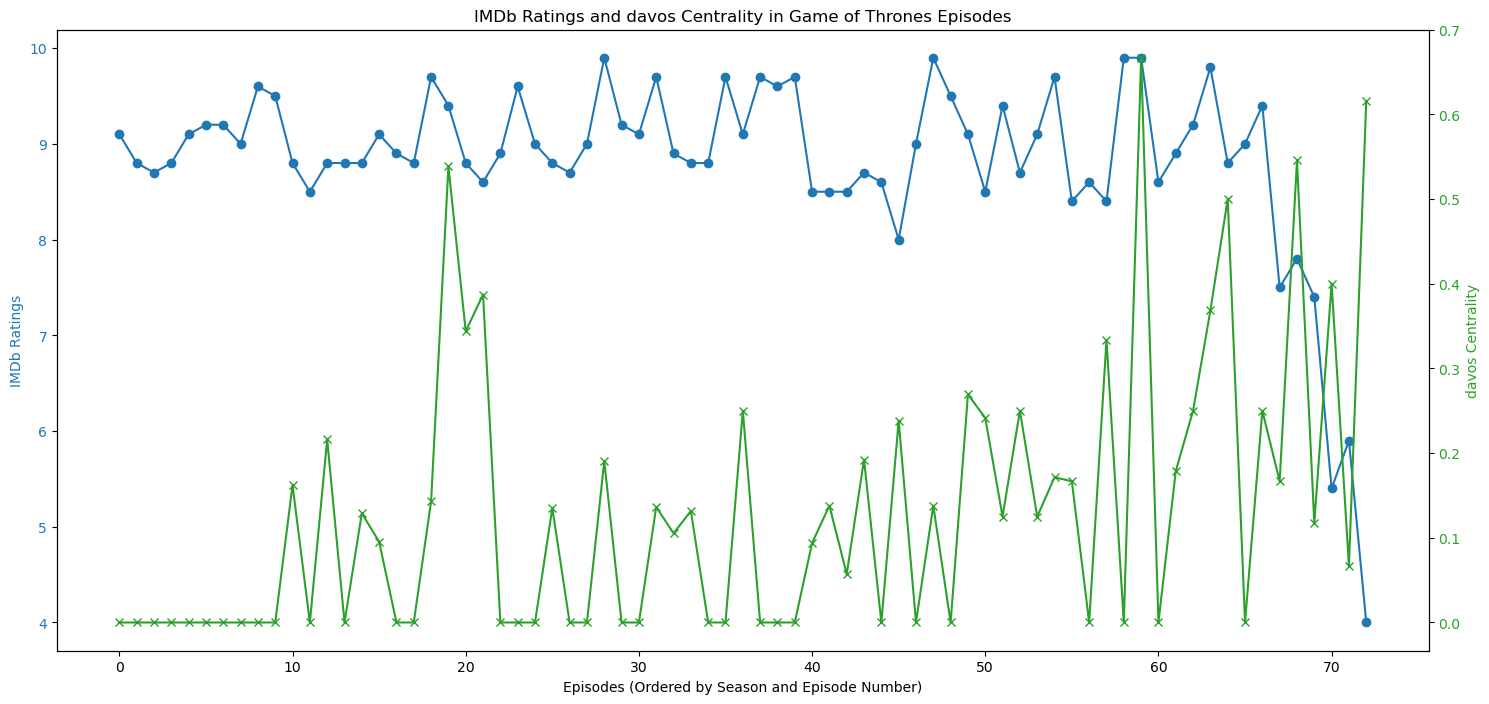

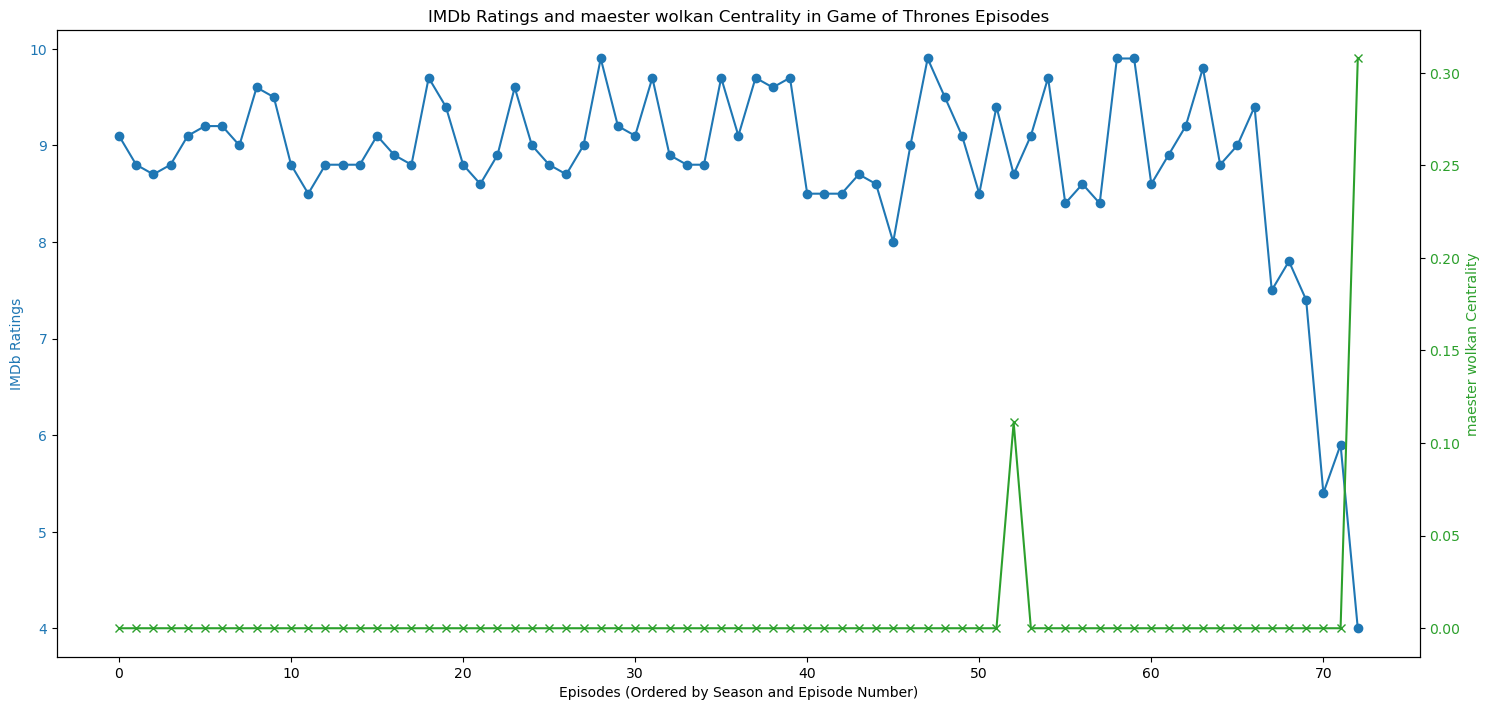

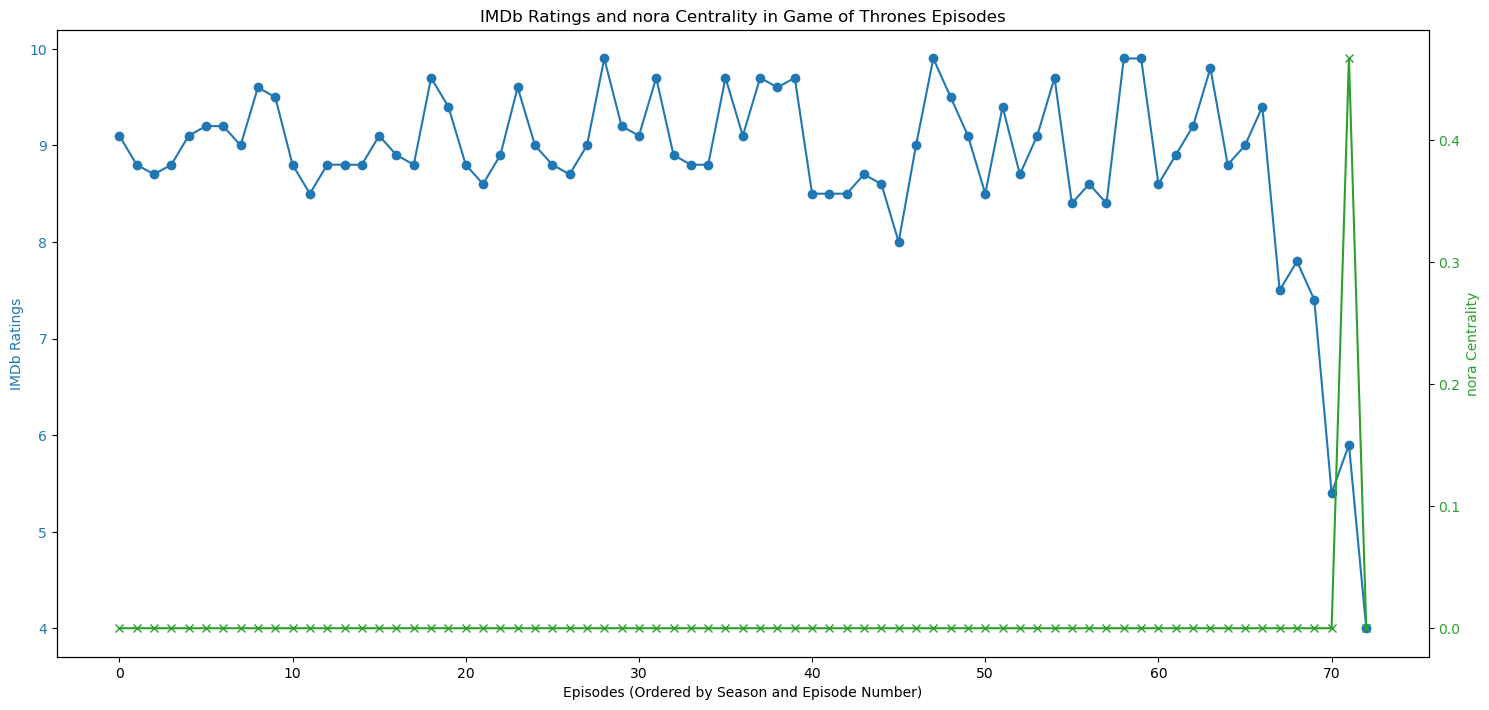

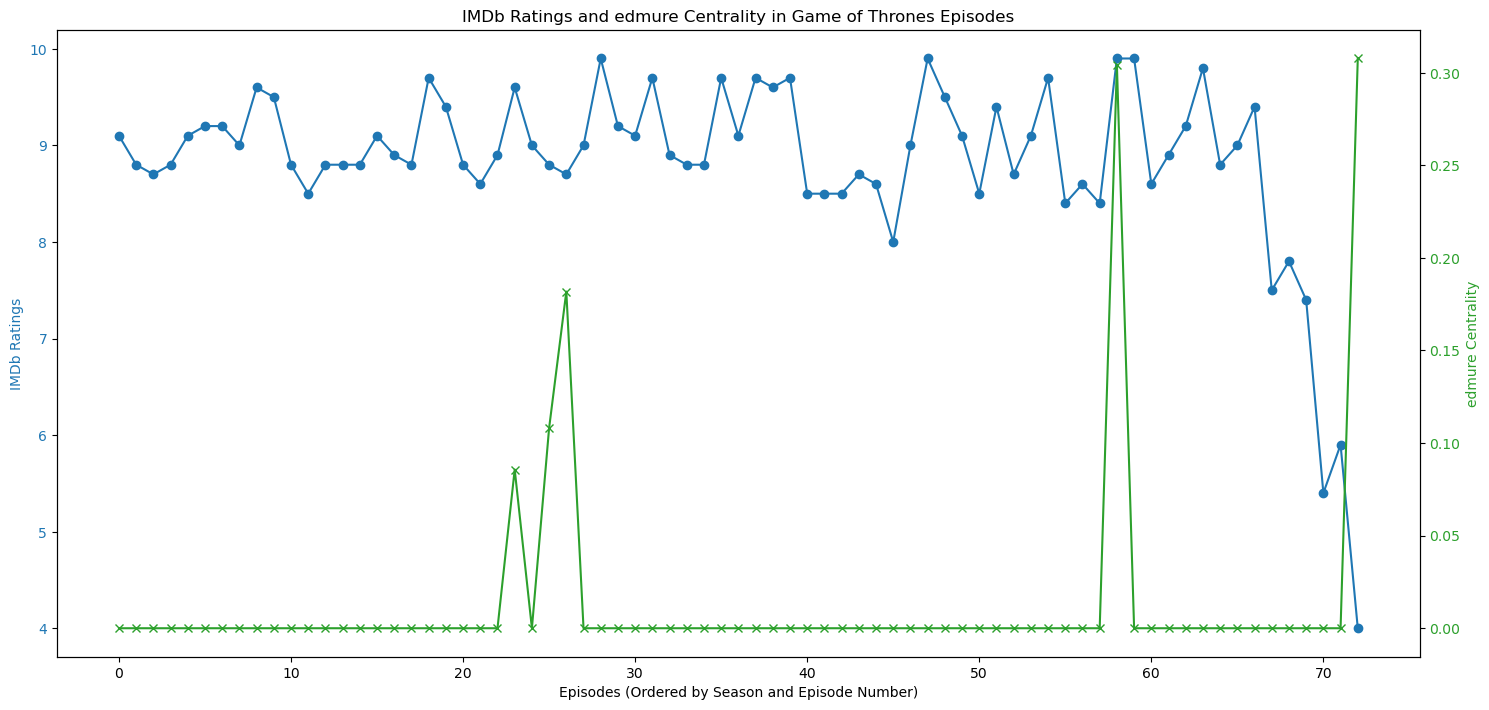

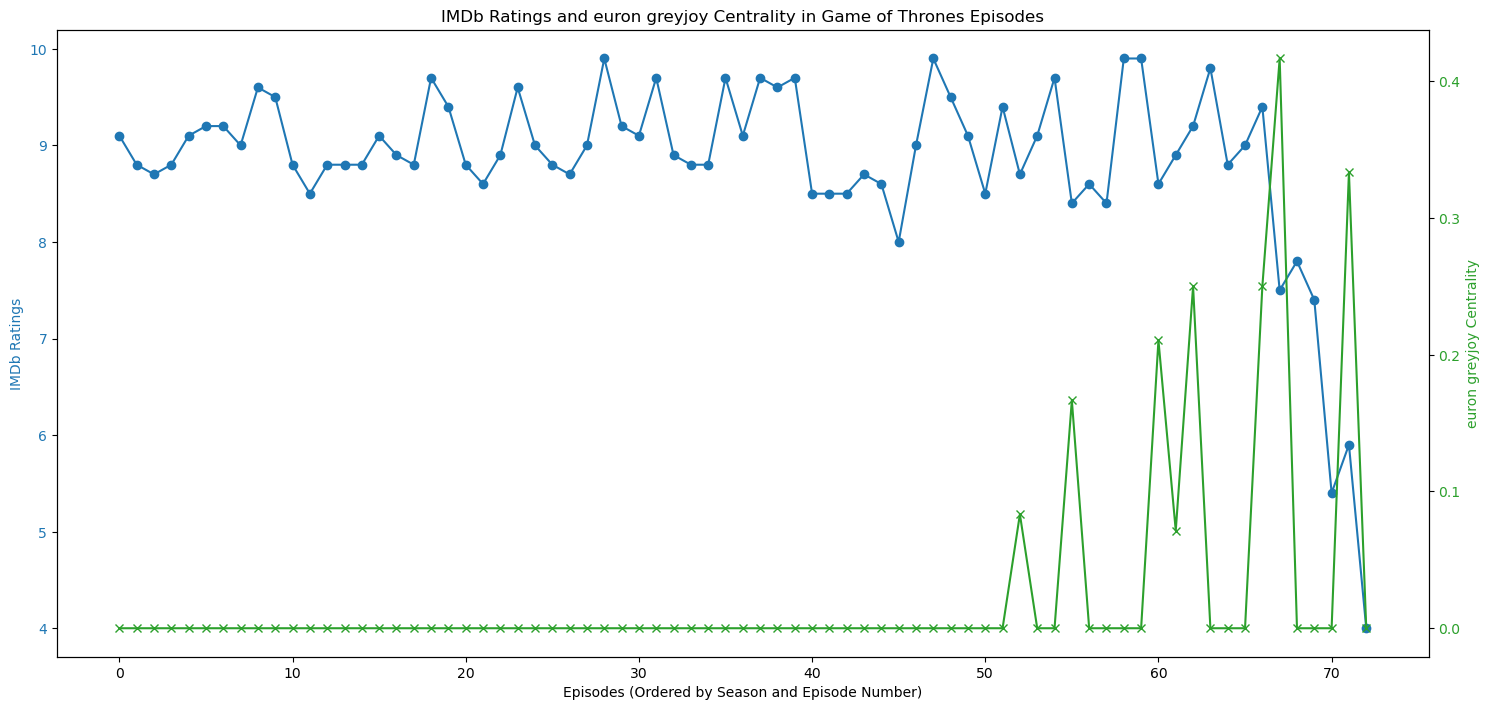

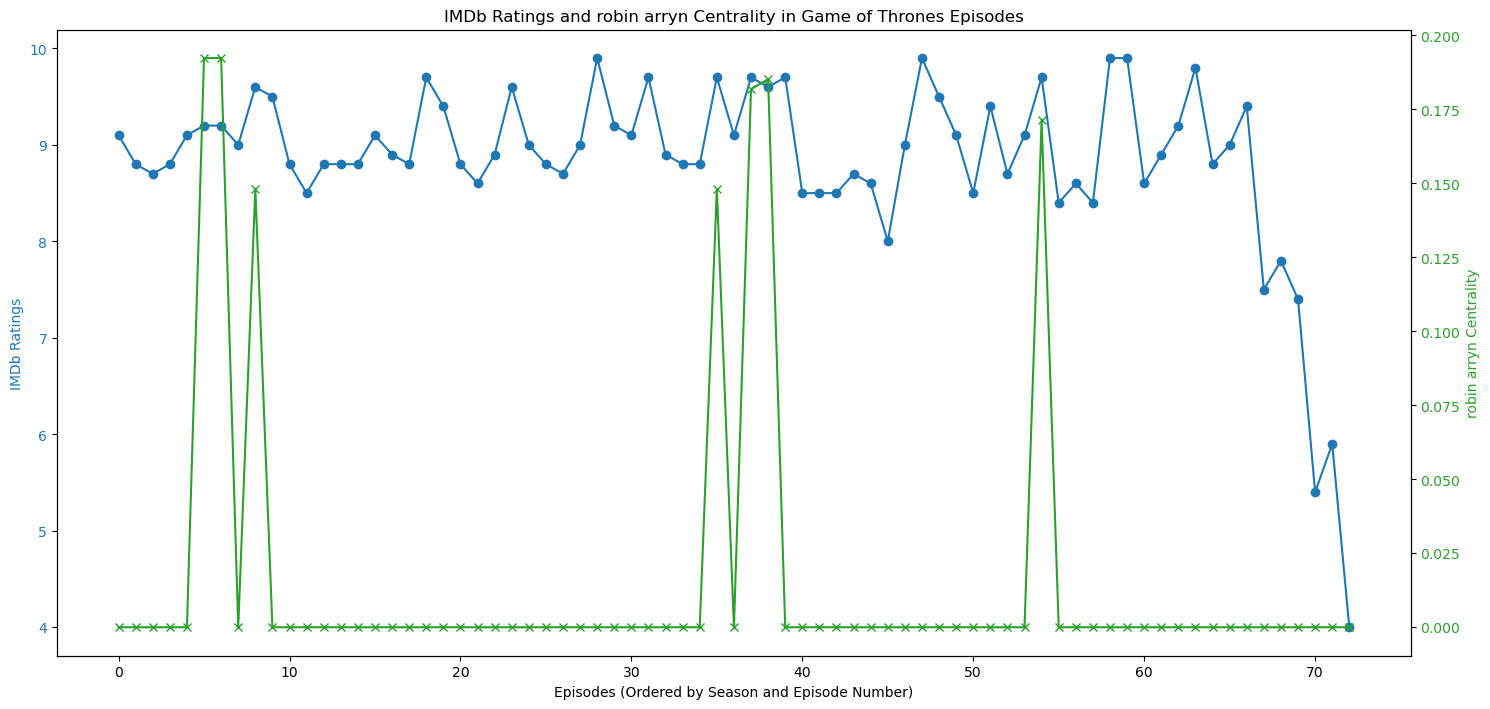

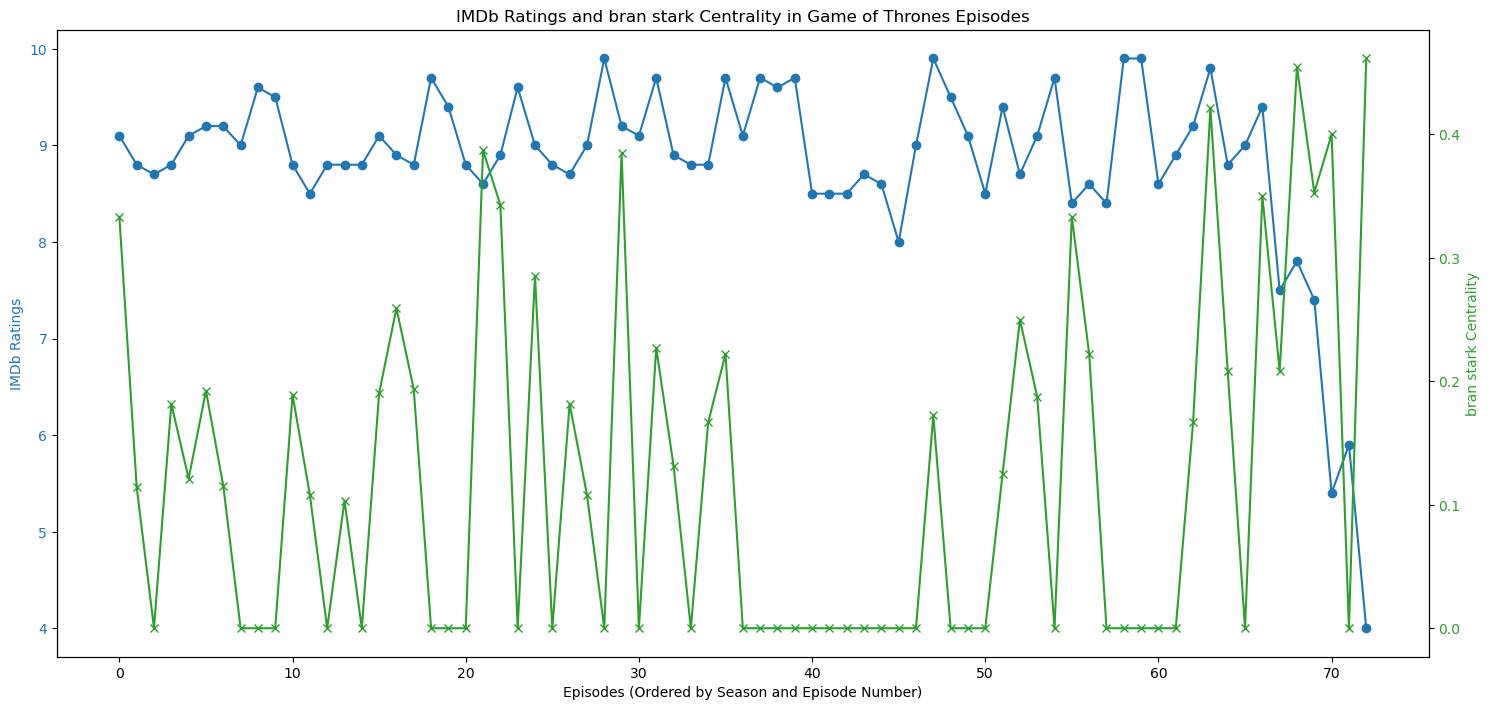

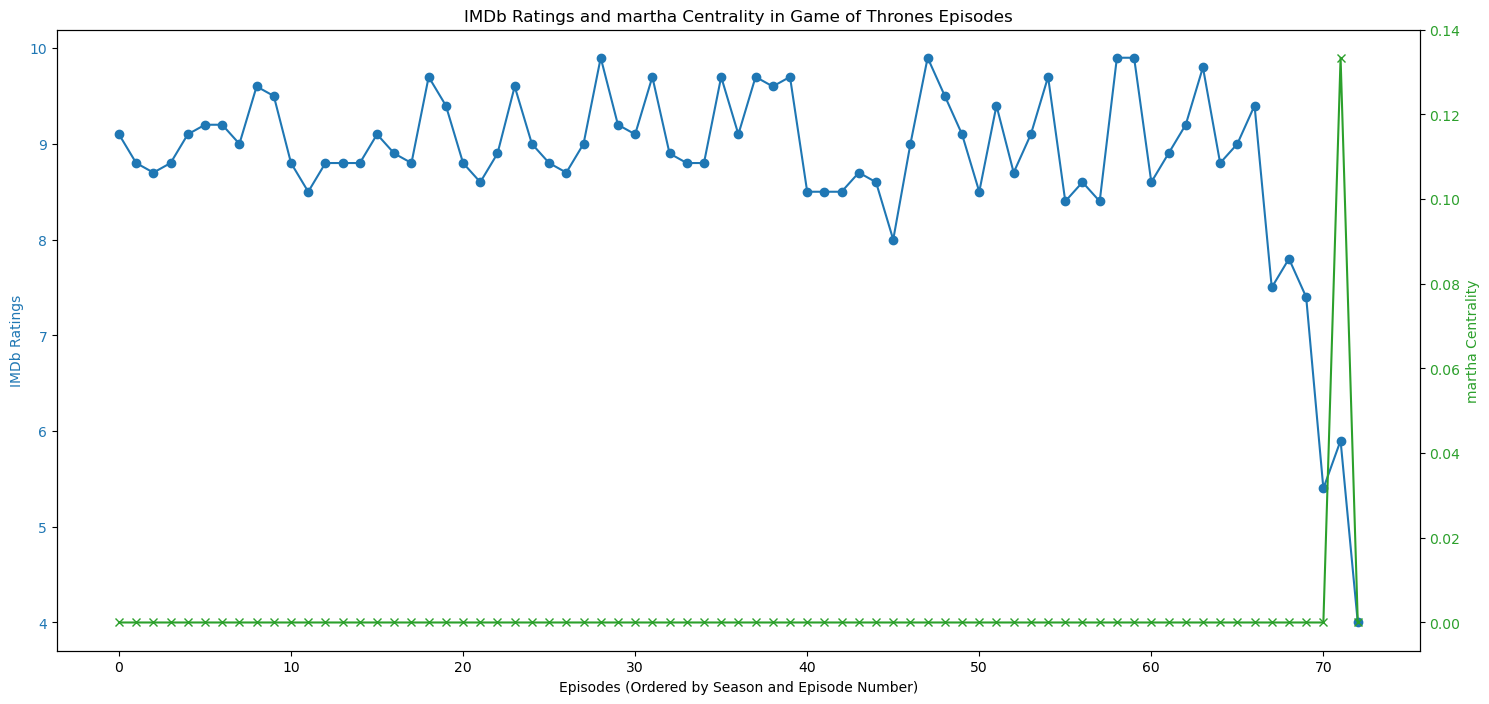

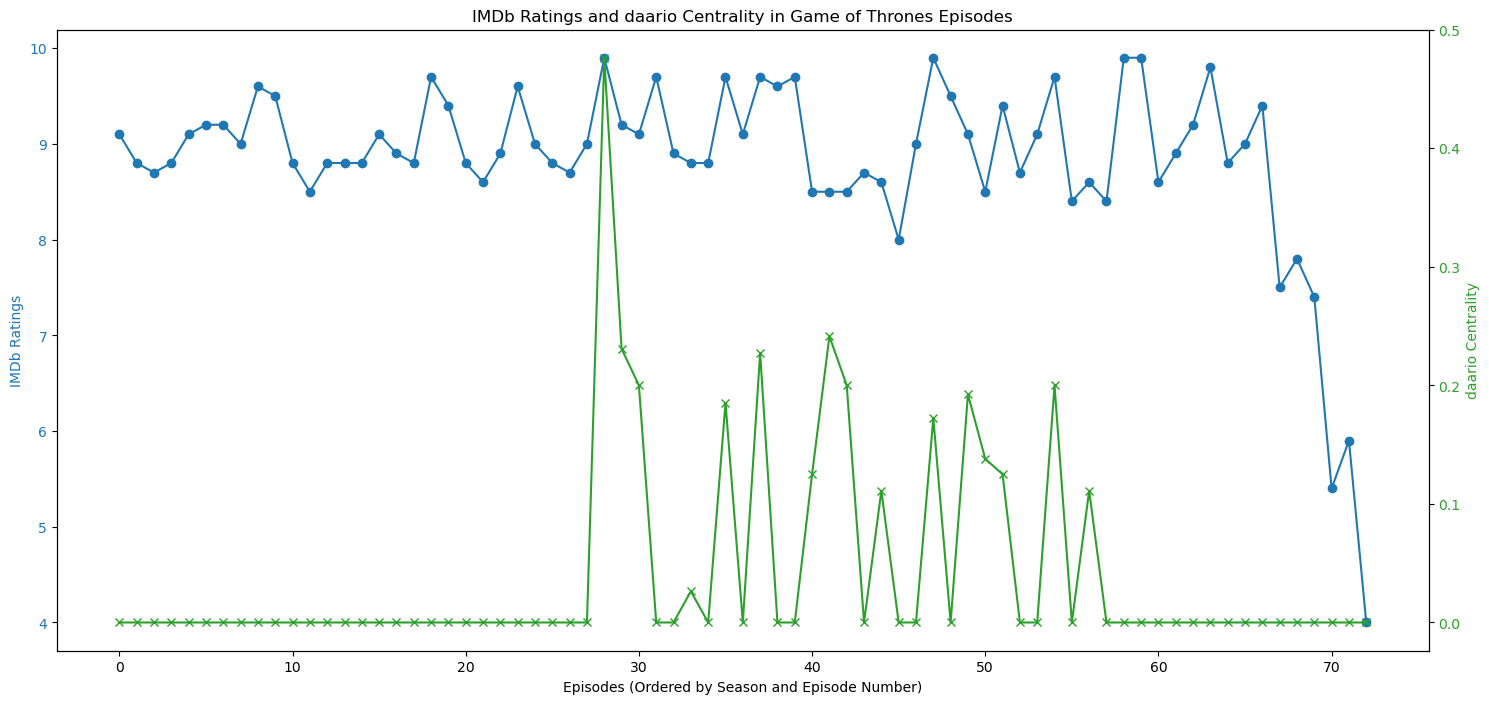

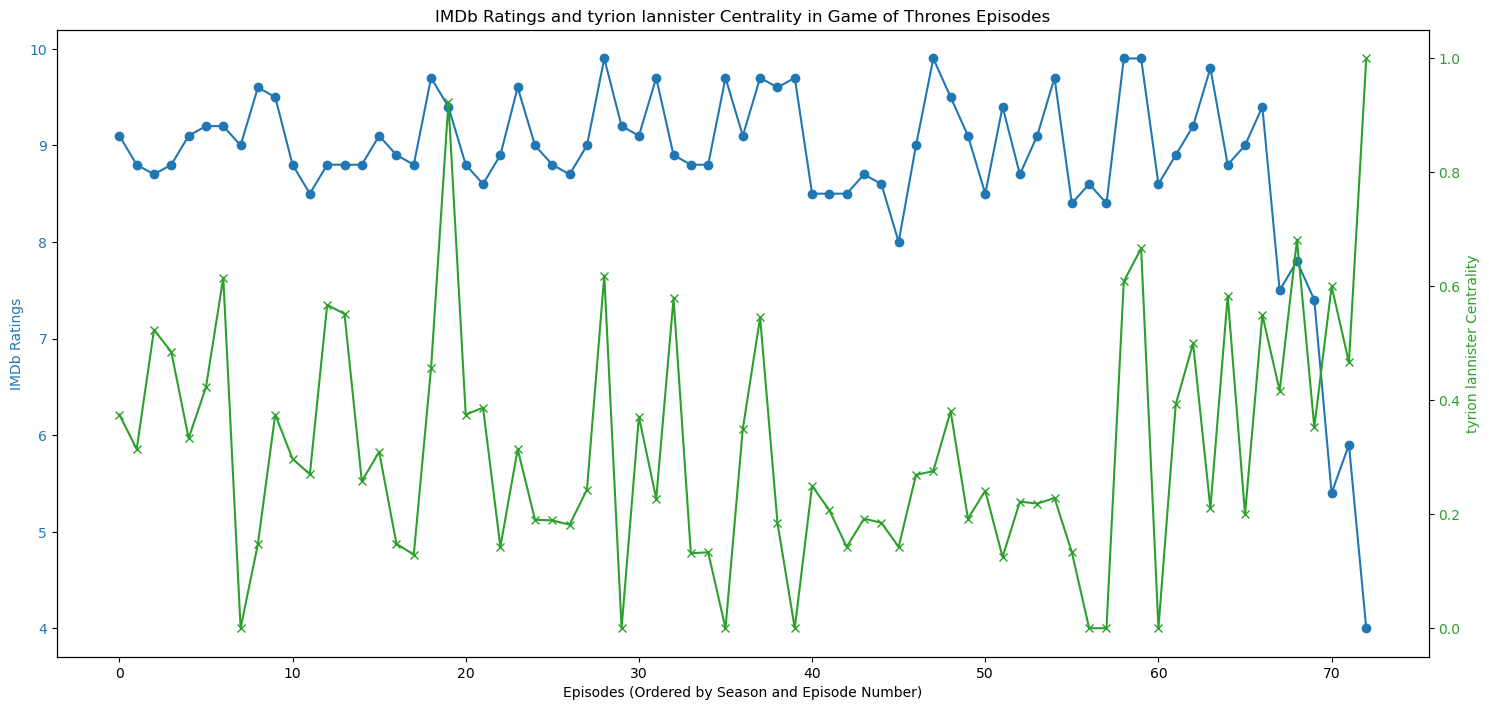

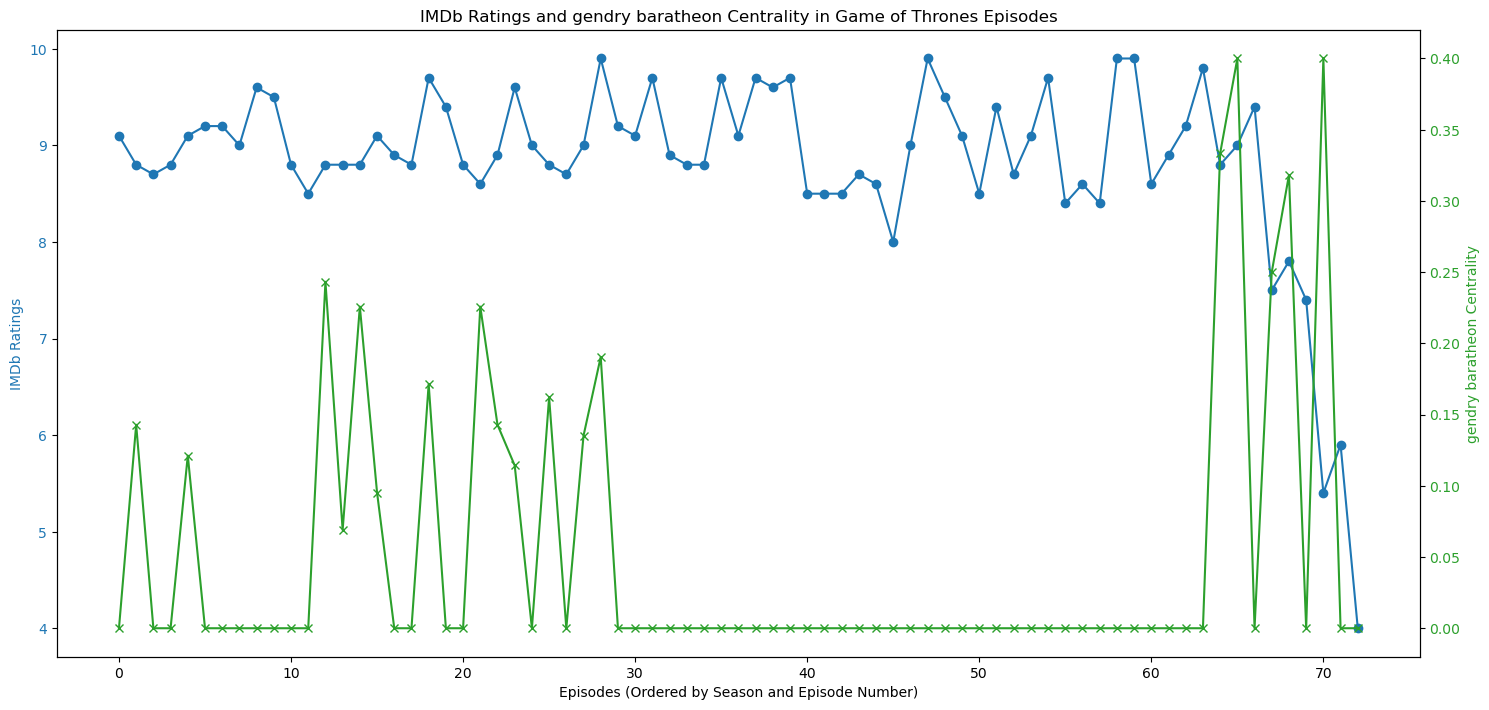

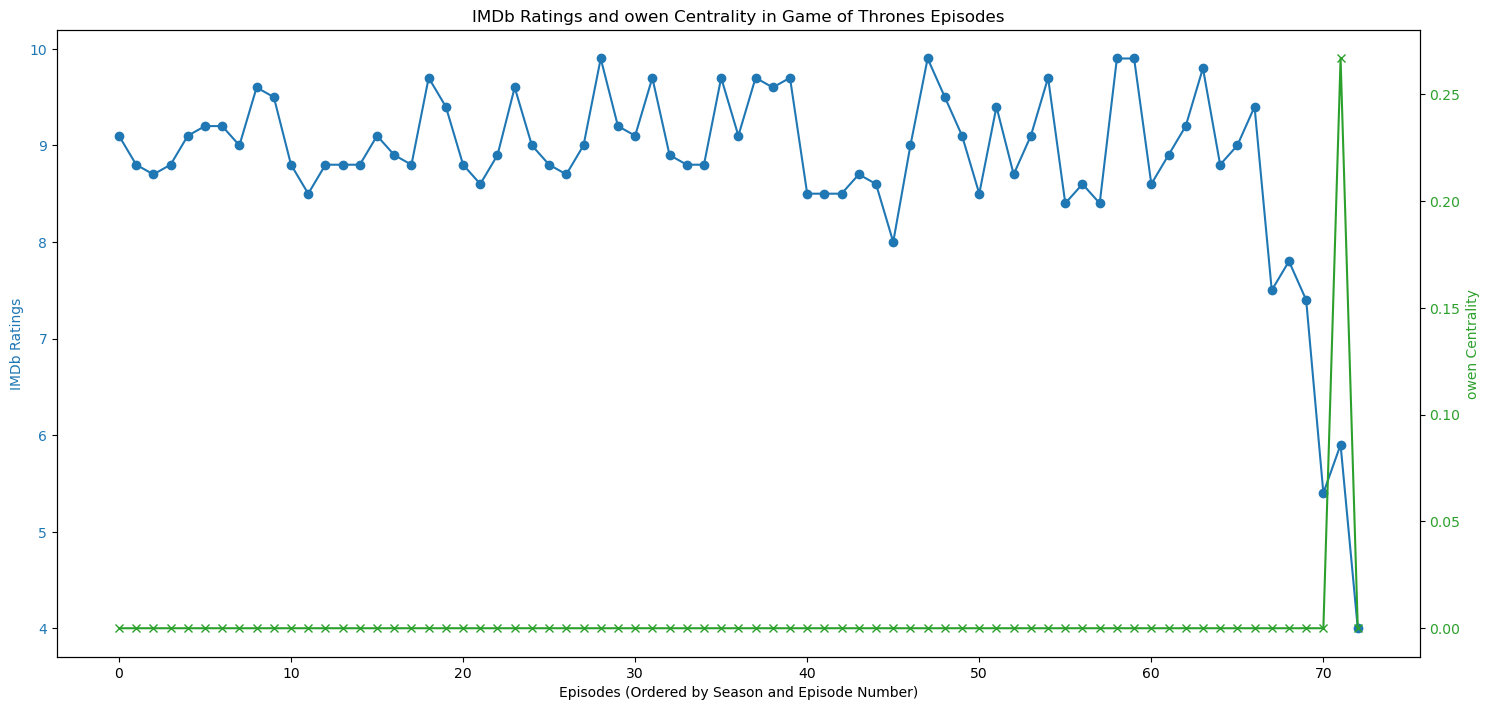

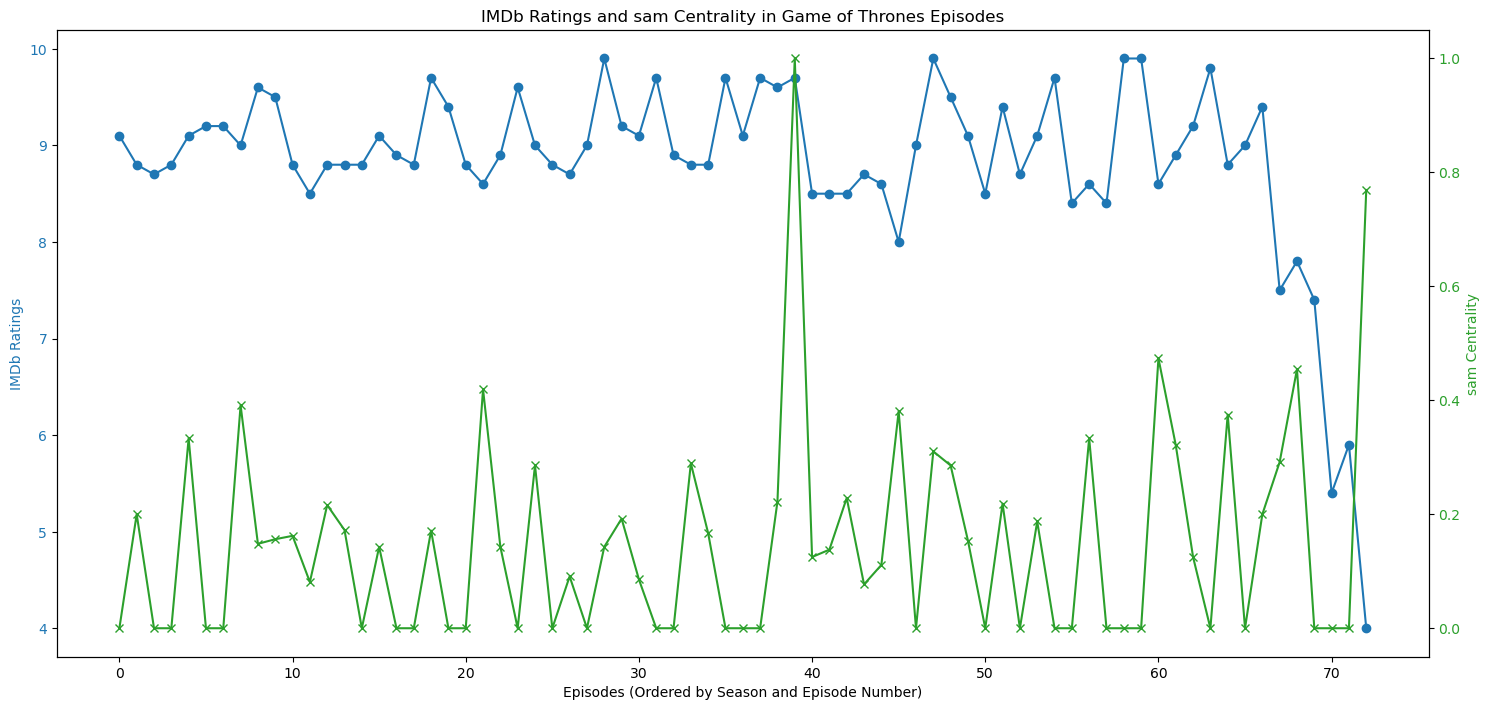

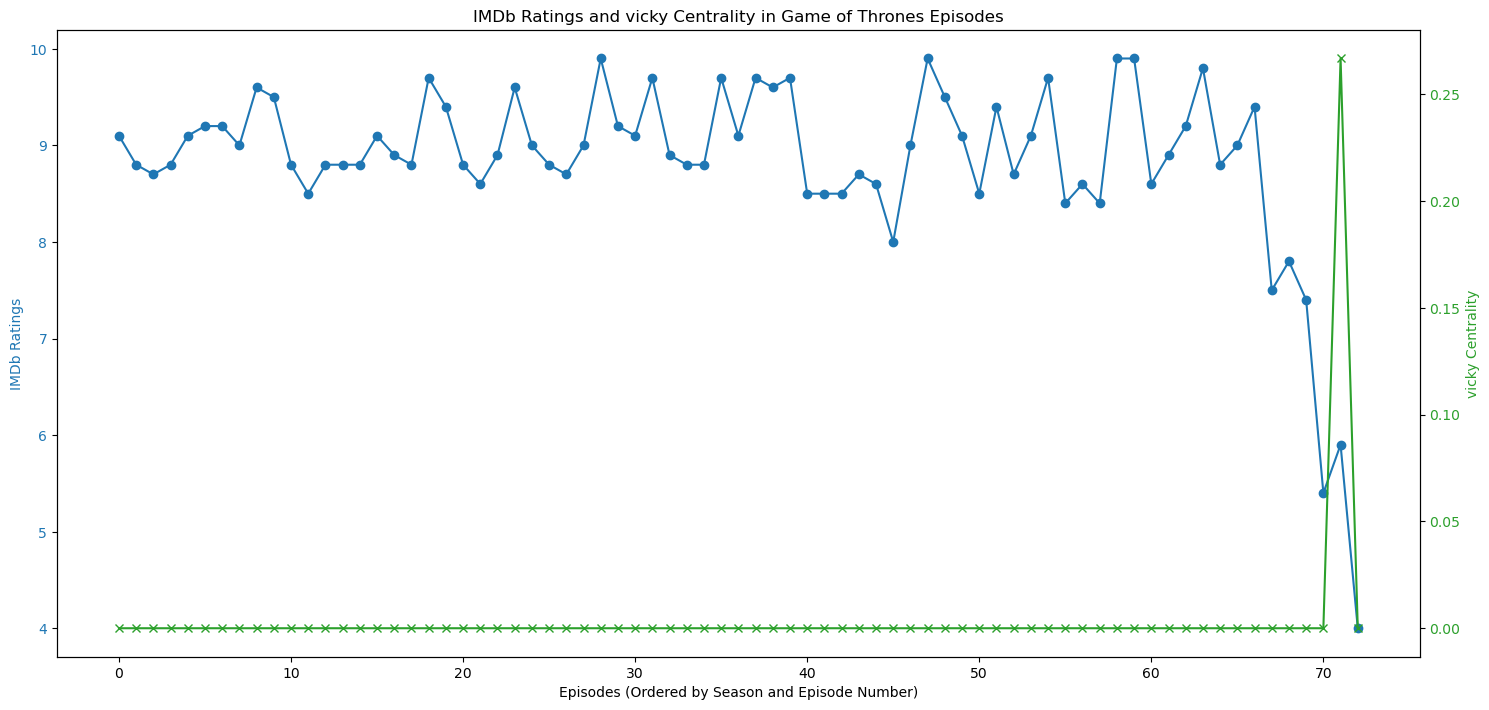

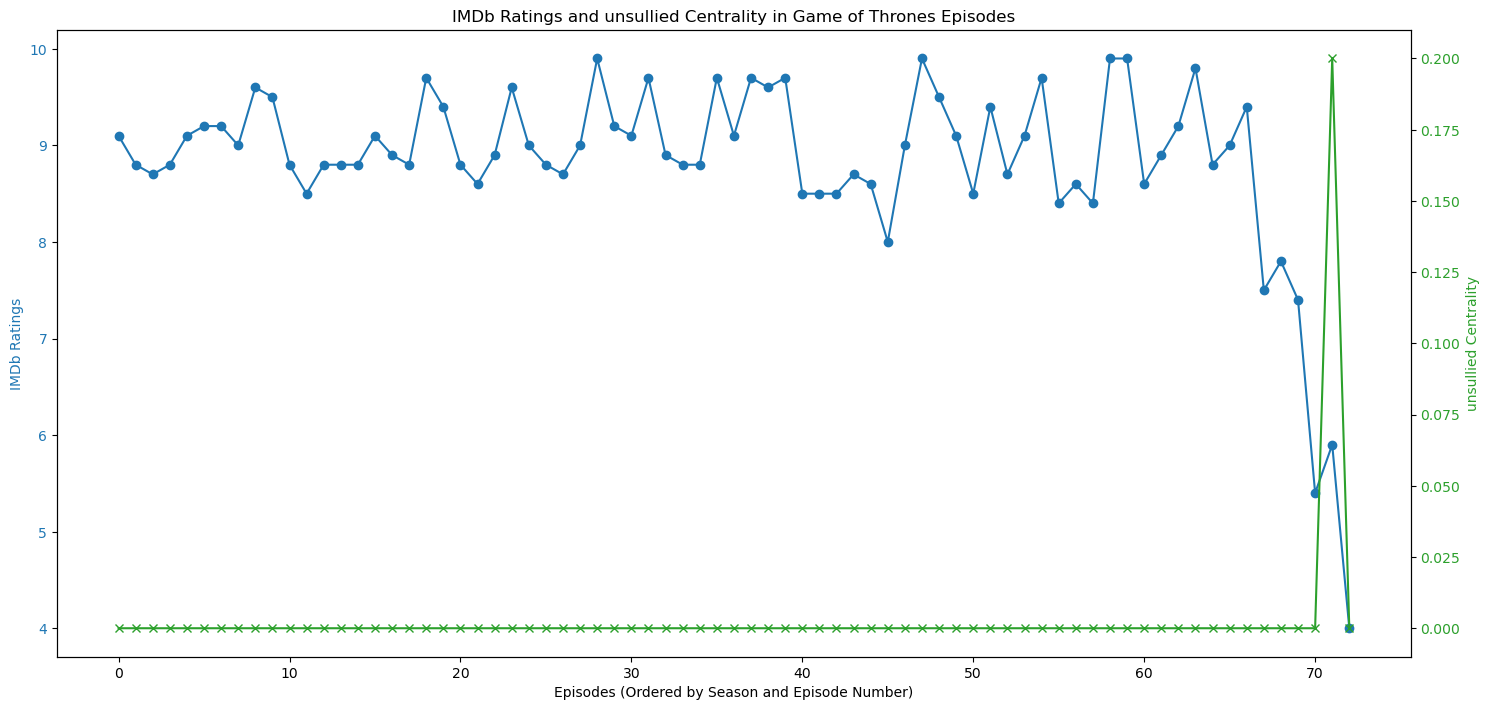

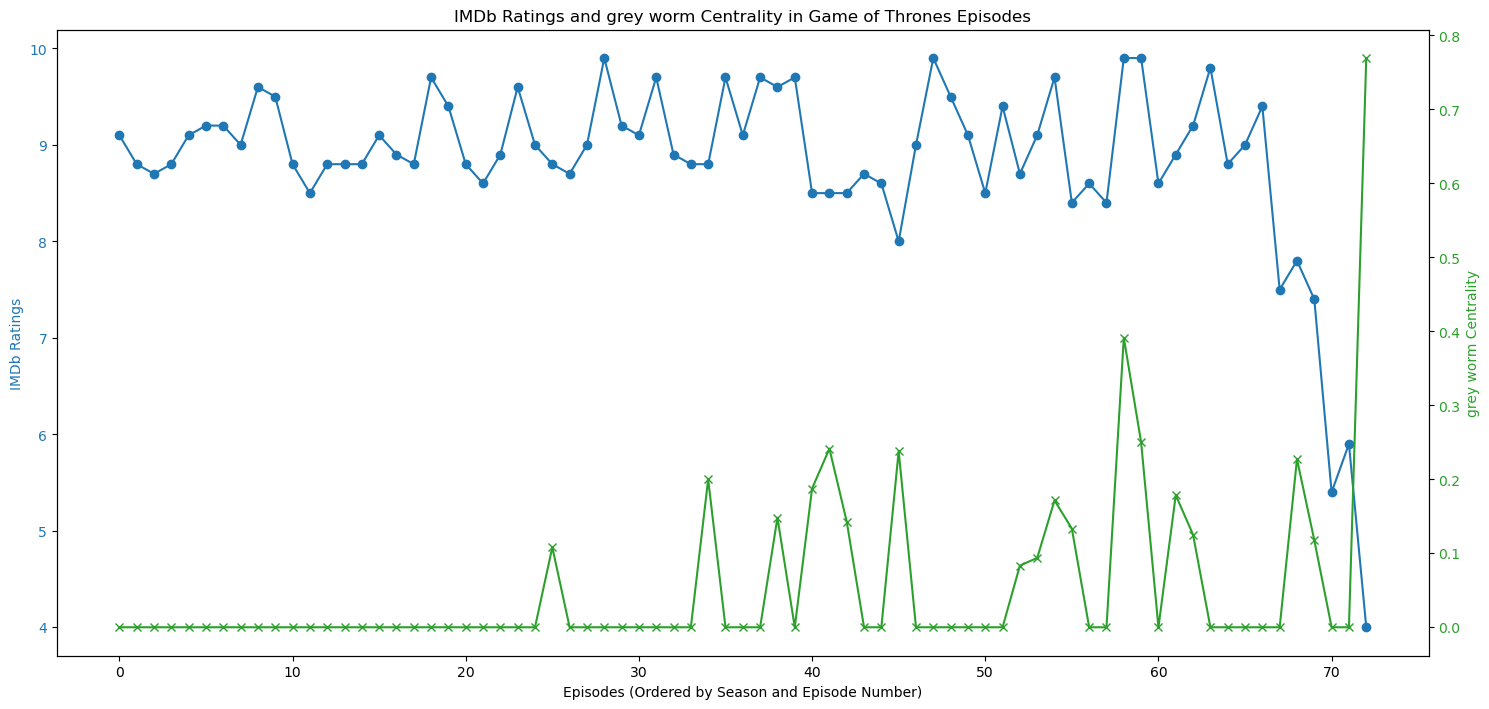

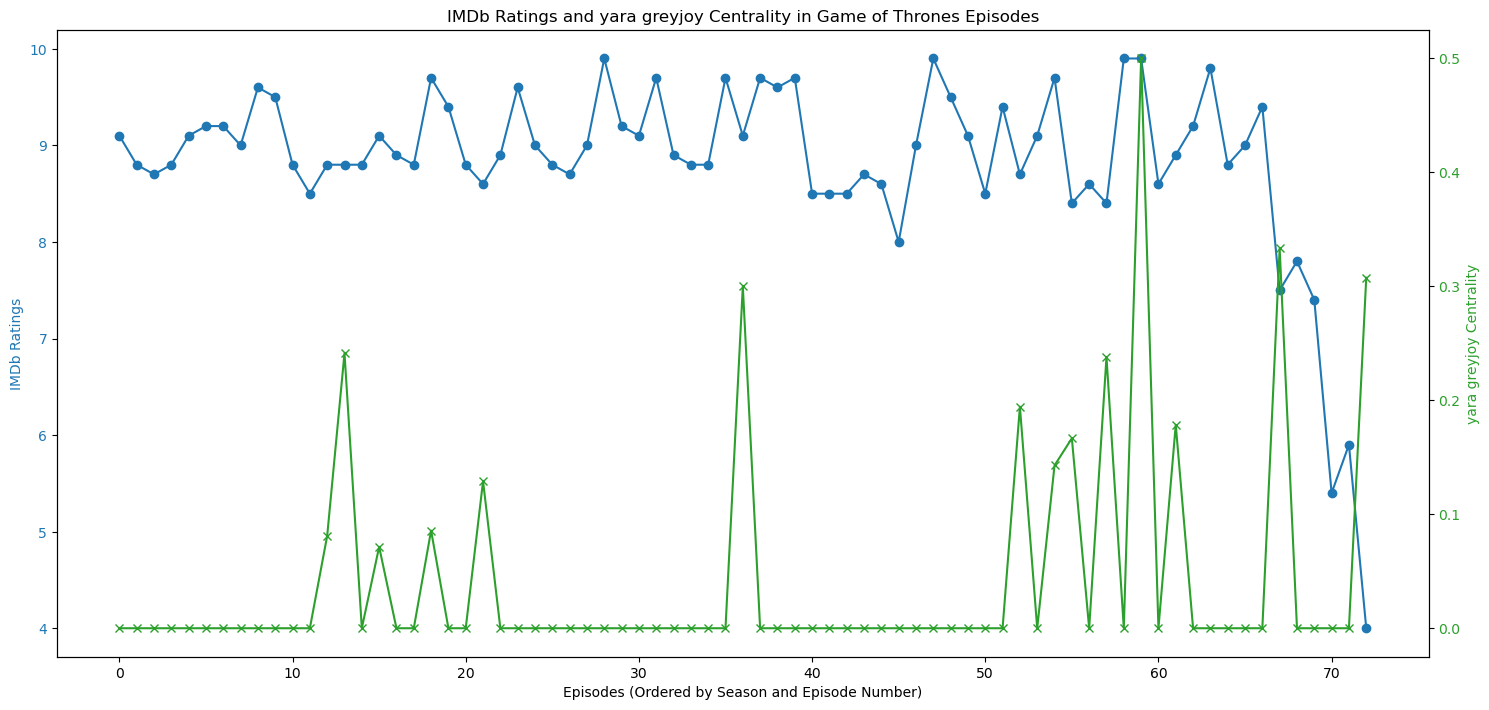

In [7]:
import matplotlib.pyplot as plt

# Identifying the characters with significant correlations
significant_characters = [char for char, (corr, sig) in character_correlations.items() if sig]

# Creating plots for each significant character
for character in significant_characters:
    character_centrality = [all_character_centrality.get(key, {}).get(character, 0) for key in sorted(all_character_centrality)]

    fig, ax1 = plt.subplots(figsize=(15, 7))

    color = 'tab:blue'
    ax1.set_xlabel('Episodes (Ordered by Season and Episode Number)')
    ax1.set_ylabel('IMDb Ratings', color=color)
    ax1.plot(ordered_imdb_scores, color=color, marker='o', label='IMDb Ratings')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:green'
    ax2.set_ylabel(f'{character} Centrality', color=color)
    ax2.plot(character_centrality, color=color, marker='x', label=f'{character} Centrality')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.title(f'IMDb Ratings and {character} Centrality in Game of Thrones Episodes')
    plt.show()


In [8]:
import pandas as pd
import networkx as nx
from collections import Counter
import scipy.stats
import csv

# Load the Game of Thrones scripts data
got_df = pd.read_csv('Game_of_Thrones_Script.csv', delimiter=';')

# Define non-specific characters to filter out
non_specific_characters = [
    "man", "woman", "soldier", "guard", "all", "wife", "male voice", "female voice", "prostitute", "crowd",
    "militant", "thin man", "banker", "girl", "boy", "old man", "young man", "men", "women", "dying man",
    "child", "wildling", "stark guard", "populace", "maid", "storyteller", "kings landing page"
]

# Function to filter out non-specific characters from the interactions
def filter_interactions(interactions):
    filtered_interactions = Counter()
    for pair, count in interactions.items():
        if not any(char in non_specific_characters for char in pair):
            filtered_interactions[pair] = count
    return filtered_interactions

# Modified Function to Process Each Episode with Rolling Window
def process_episode_with_rolling_window(episode_df):
    interactions = Counter()
    num_lines = len(episode_df)

    for i in range(num_lines):
        window_end = min(i + 11, num_lines)  # 11 lines as a window size
        window_df = episode_df.iloc[i:window_end]

        character_counts = Counter(window_df['Name'])
        interacting_characters = [char for char, count in character_counts.items() if count > 1]

        for index, char1 in enumerate(interacting_characters):
            for char2 in interacting_characters[index + 1:]:
                interactions[frozenset([char1, char2])] += 1

    return interactions

# Function to create episode networks with filtered interactions
def create_episode_networks(got_df):
    episode_networks = {}
    for (season, episode), group_df in got_df.groupby(['Season', 'Episode']) :
        if (season != 'Season 8'):
            episode_interactions = process_episode_with_rolling_window(group_df)
            filtered_interactions = filter_interactions(episode_interactions)
            
            G = nx.Graph()
            for pair, count in filtered_interactions.items():
                char1, char2 = tuple(pair)
                G.add_edge(char1, char2, weight=count)
            episode_networks[(season, episode)] = G
    return episode_networks

# Function to calculate centrality for all characters in each episode
def calculate_all_character_centrality(episode_networks):
    character_centrality = {}
    for key, G in episode_networks.items():
        centrality = nx.degree_centrality(G)
        character_centrality[key] = centrality
    return character_centrality

# Create episode networks
episode_networks = create_episode_networks(got_df)

# Calculate centrality for all characters
all_character_centrality = calculate_all_character_centrality(episode_networks)

# Now, parse the IMDb scores
def parse_got_csv(file_path):
    episodes = {}

    with open(file_path, mode='r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        for row in reader:
            season = int(row['Season'])
            episode = int(row['Episode'])
            title = row['Title']
            rating = float(row['Rating'])

            if (season != 8):
                key = (season, episode)
                episodes[key] = {
                    'season': season,
                    'episode': episode,
                    'title': title,
                    'rating': rating
                }
    return episodes

# Parse IMDb data
got_imdb_data = parse_got_csv('got_imdb.csv')

# Extract IMDb scores for each episode
imdb_scores = {key: value['rating'] for key, value in got_imdb_data.items()}

all_character_centrality, imdb_scores



({('Season 1', 'Episode 1'): {'will': 0.25,
   'waymar royce': 0.16666666666666666,
   'gared': 0.16666666666666666,
   'jon snow': 0.5833333333333333,
   'septa mordane': 0.16666666666666666,
   'eddard stark': 0.8333333333333333,
   'rodrik cassel': 0.16666666666666666,
   'catelyn stark': 0.7083333333333333,
   'robb stark': 0.375,
   'bran stark': 0.3333333333333333,
   'theon greyjoy': 0.20833333333333331,
   'jaime lannister': 0.3333333333333333,
   'cersei lannister': 0.41666666666666663,
   'robert baratheon': 0.5,
   'arya stark': 0.20833333333333331,
   'sansa stark': 0.4583333333333333,
   'tyrion lannister': 0.375,
   'ros': 0.16666666666666666,
   'viserys targaryen': 0.375,
   'daenerys targaryen': 0.375,
   'illyrio': 0.25,
   'benjen stark': 0.29166666666666663,
   'luwin': 0.16666666666666666,
   'jorah mormont': 0.125,
   'sandor clegane': 0.16666666666666666},
  ('Season 1', 'Episode 10'): {'bran stark': 0.11428571428571428,
   'yoren': 0.17142857142857143,
   'osha'

In [9]:
# Function to calculate the Pearson correlation coefficient between IMDb scores and character centrality
def episode_correlation(episodes, values, significance=0.10):
    """
    Calculate the Pearson correlation coefficient between IMDb scores and given values at the episode level.

    Args:
    episodes (list): List of IMDb scores for each episode.
    values (list): Corresponding values (like centrality scores) to check correlation with IMDb scores.
    significance (float): The significance level to determine statistical significance (default is 0.05).

    Returns:
    tuple: (Pearson correlation coefficient, boolean indicating significance)
    """
    if len(episodes) != len(values):
        raise ValueError("Length of episodes and values must be the same.")

    correlation, p_value = scipy.stats.pearsonr(episodes, values)
    is_significant = p_value < significance
    return correlation, is_significant

# Extract the IMDb scores in the order of episodes as they appear in the centrality data
ordered_imdb_scores = [imdb_scores[key] for key in sorted(imdb_scores)]

# Dictionary to hold correlation results for each character
character_correlations = {}

# Iterate through each character and calculate the correlation with IMDb scores
for character in set().union(*[set(centrality.keys()) for centrality in all_character_centrality.values()]):
    centrality_scores = [all_character_centrality.get(key, {}).get(character, 0) for key in sorted(all_character_centrality)]
    
    # Calculate correlation if the character appears in at least one episode
    if any(centrality_scores):
        correlation, is_significant = episode_correlation(ordered_imdb_scores, centrality_scores)
        character_correlations[character] = (correlation, is_significant)

character_correlations





{'yohn': (0.03946036982018773, False),
 'morag': (0.17716061867188507, False),
 'black lorren': (-0.09985846409033347, False),
 'waitress': (-0.15331997857218843, False),
 'davos': (0.025817087170911093, False),
 'luwin': (-0.1326396915040896, False),
 'styr': (0.14749737234099544, False),
 'joffrey dwarf': (-0.043159779490830406, False),
 'morgans friend': (0.011920320049848334, False),
 'black walder': (-0.2358530817659473, True),
 'tobho mott': (0.011920320049848335, False),
 'lommy': (-0.0706998292611697, False),
 'shae': (-0.04131896140122813, False),
 'robert baratheon': (-0.017709888262363402, False),
 'mord': (0.039460369820187656, False),
 'torturer': (-0.04315977949083039, False),
 'moles town madam': (-0.07069982926116974, False),
 'alliser throne': (0.011920320049848337, False),
 'hot pie': (0.0697410387253132, False),
 'master': (0.12208051913120638, False),
 'grand maester pycelle': (0.14688029504169592, False),
 'grenn': (0.172841974917838, False),
 'yezzan': (0.17716061

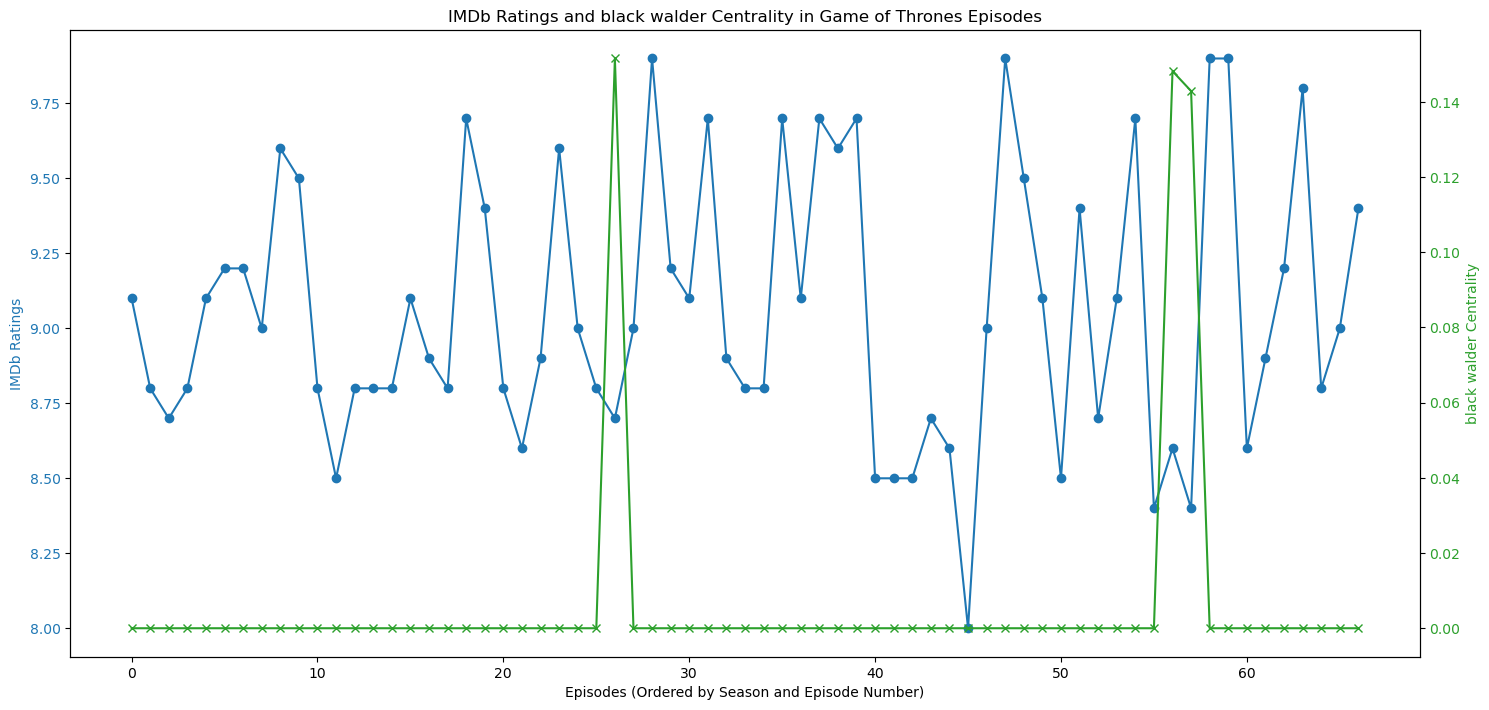

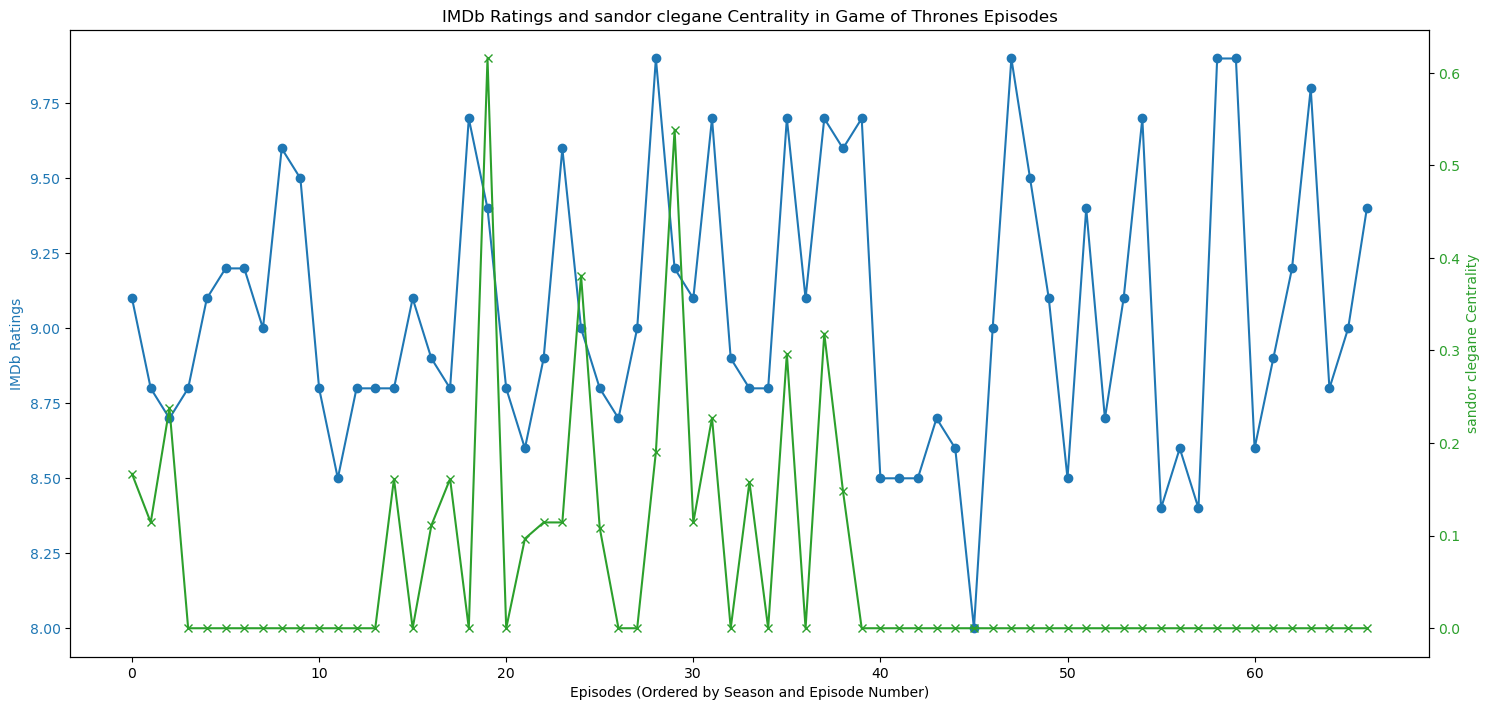

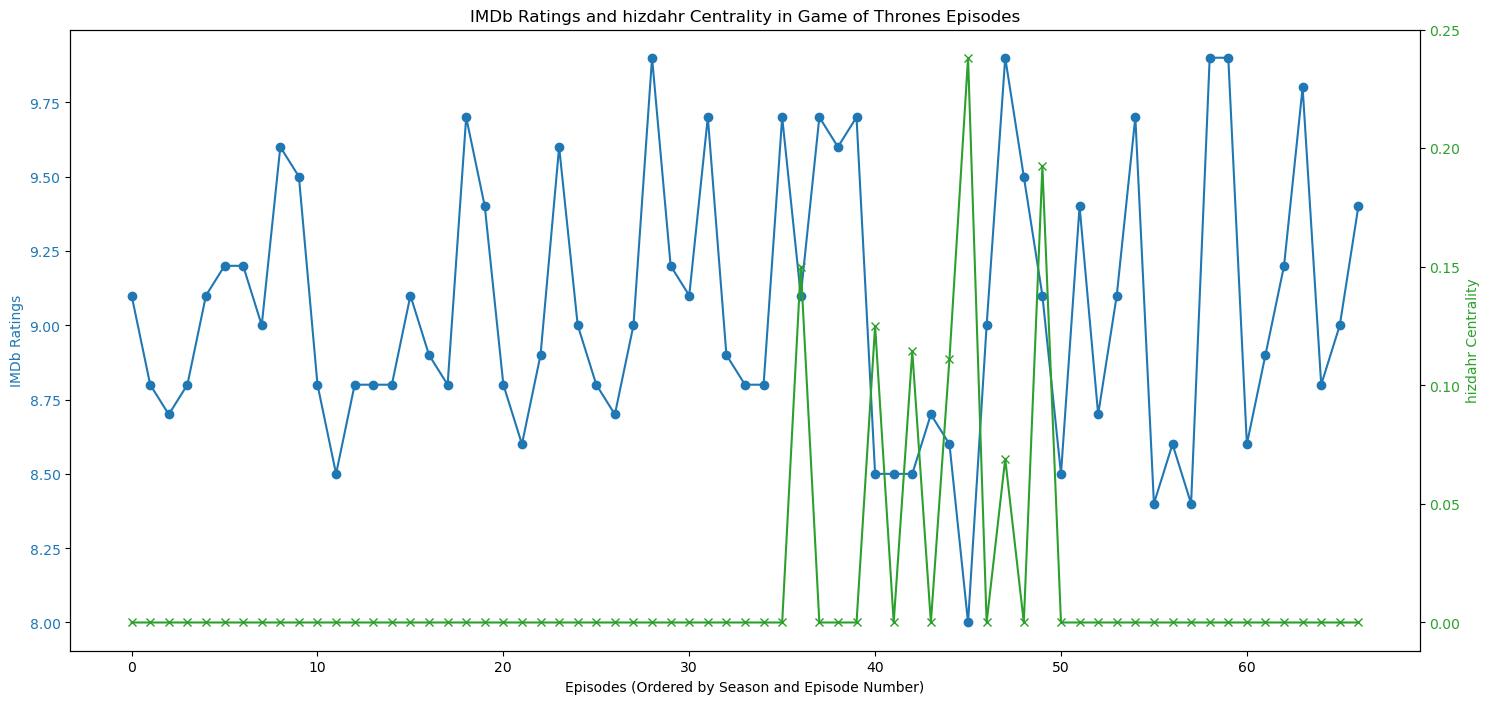

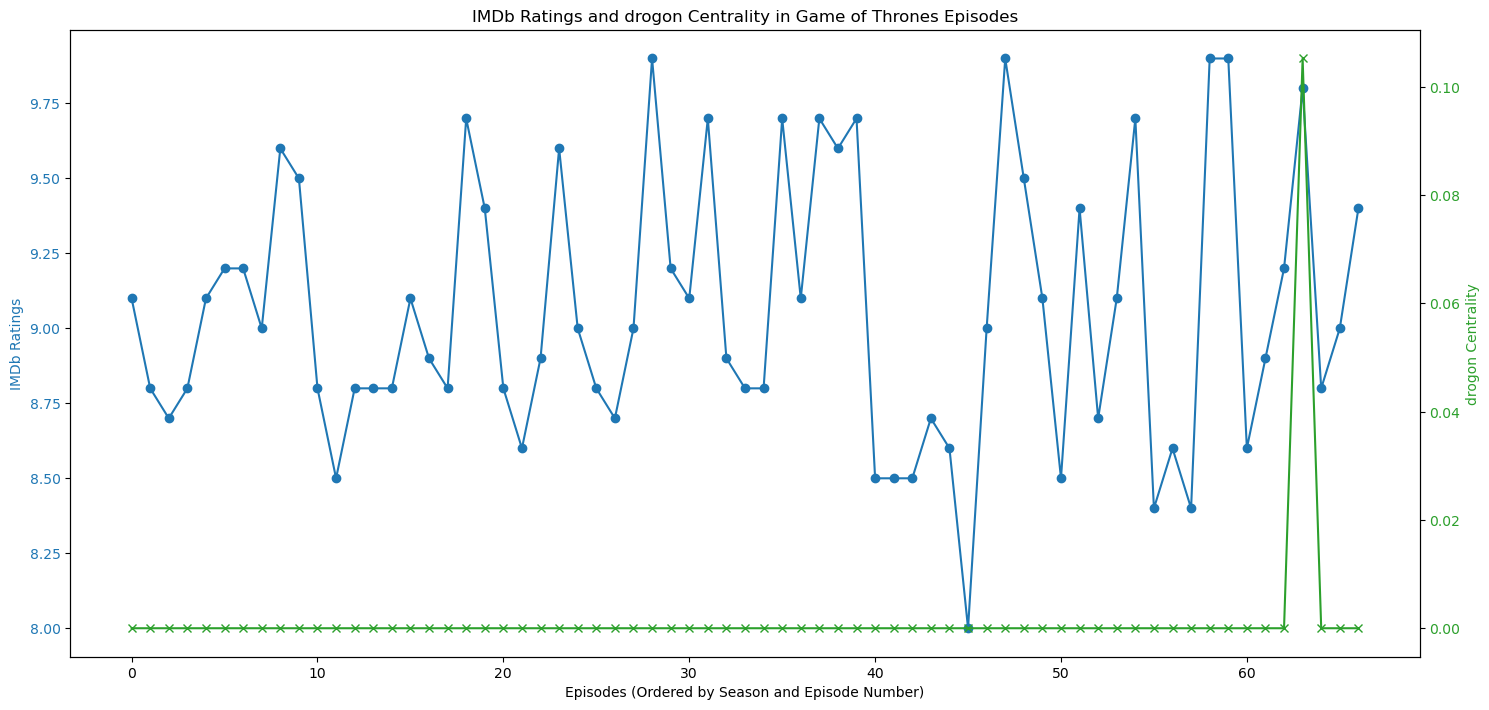

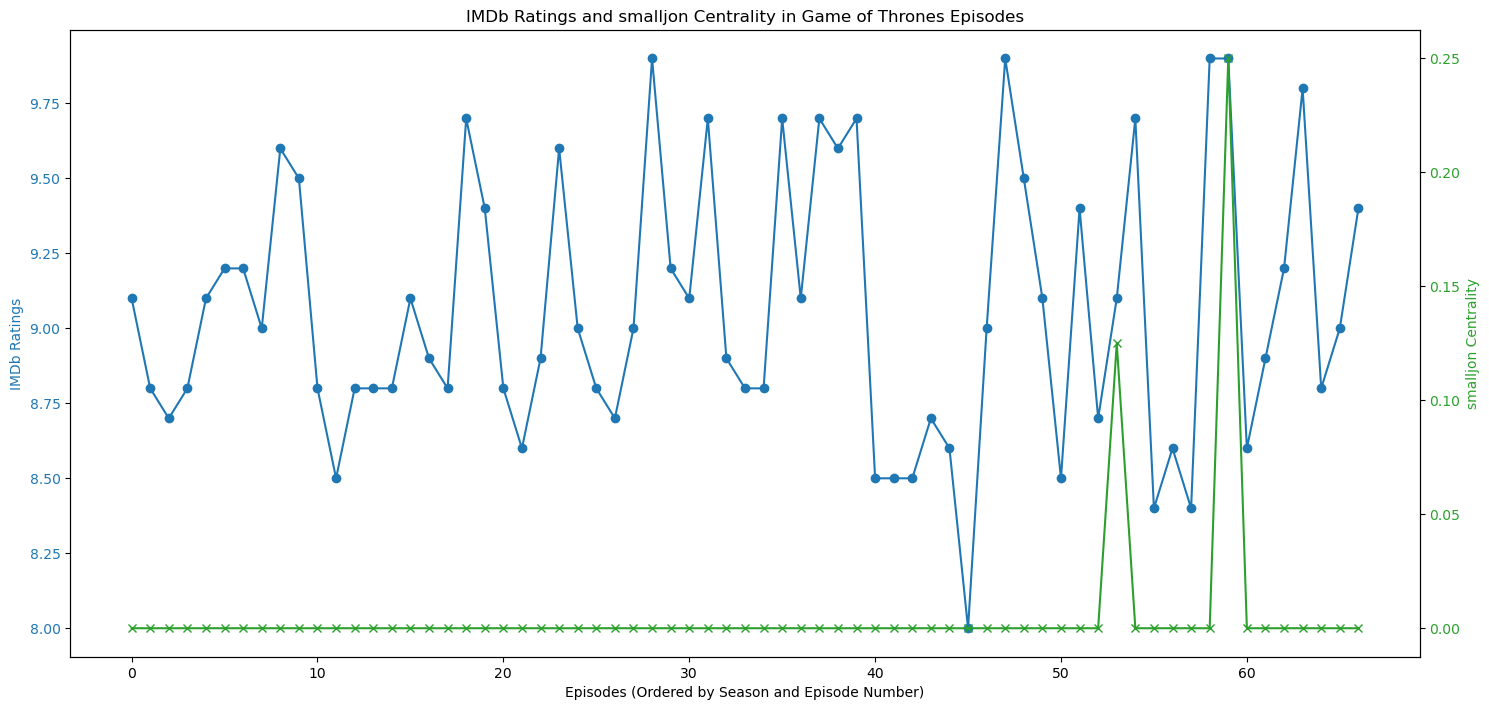

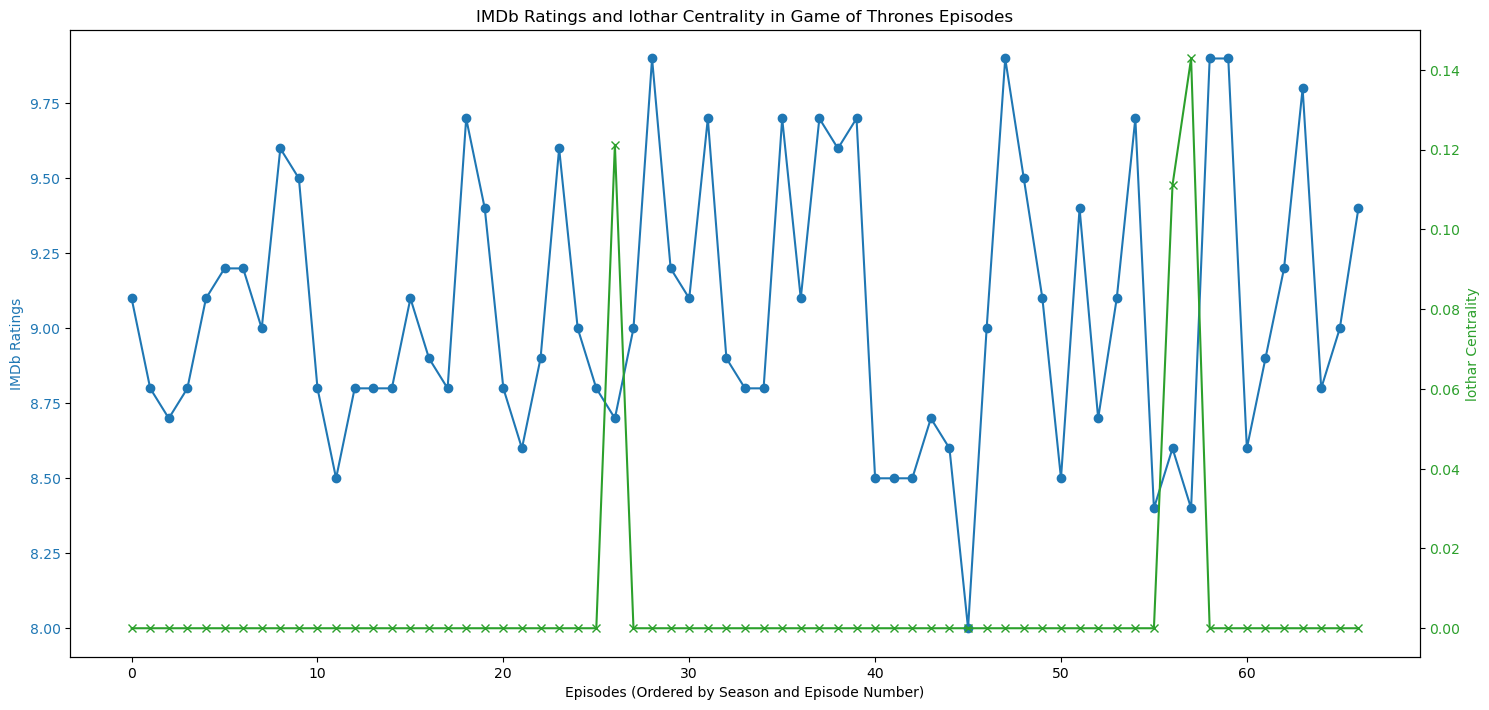

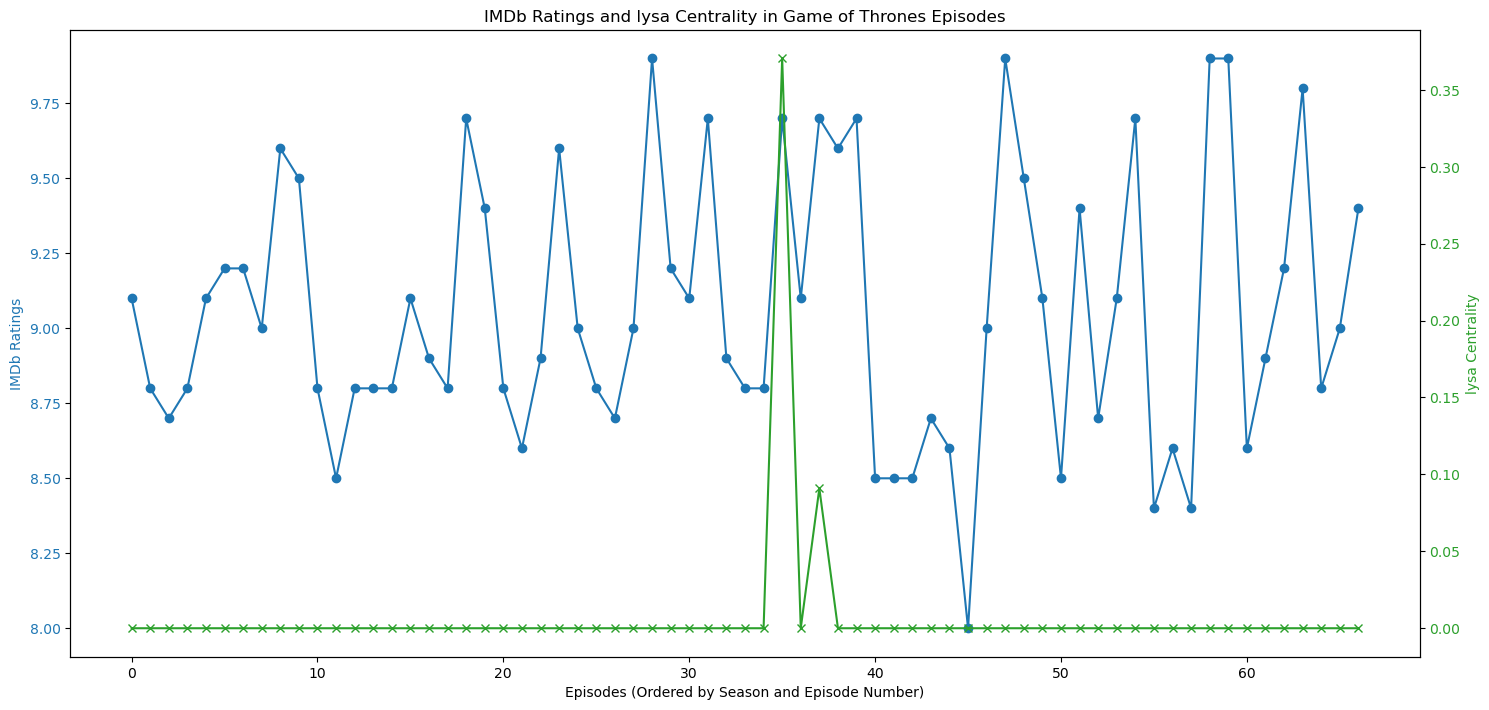

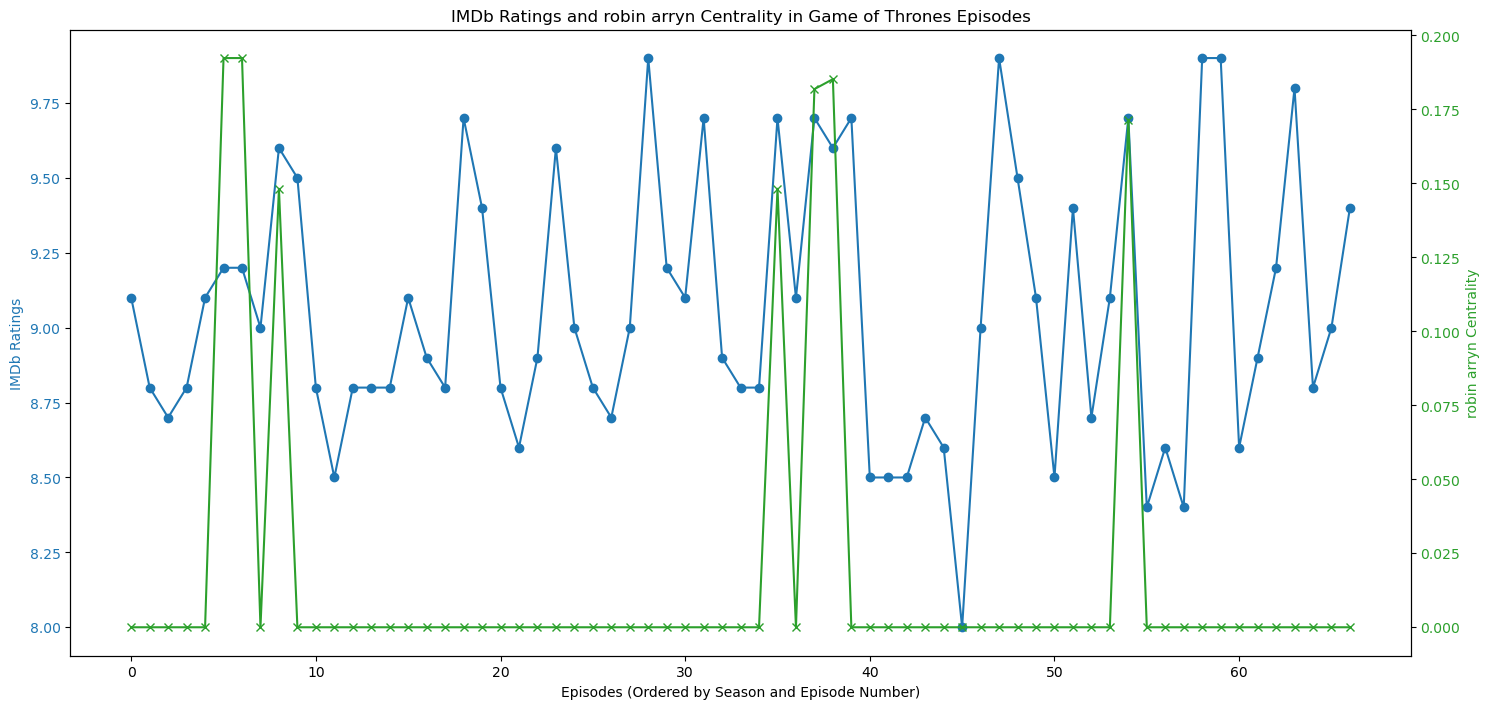

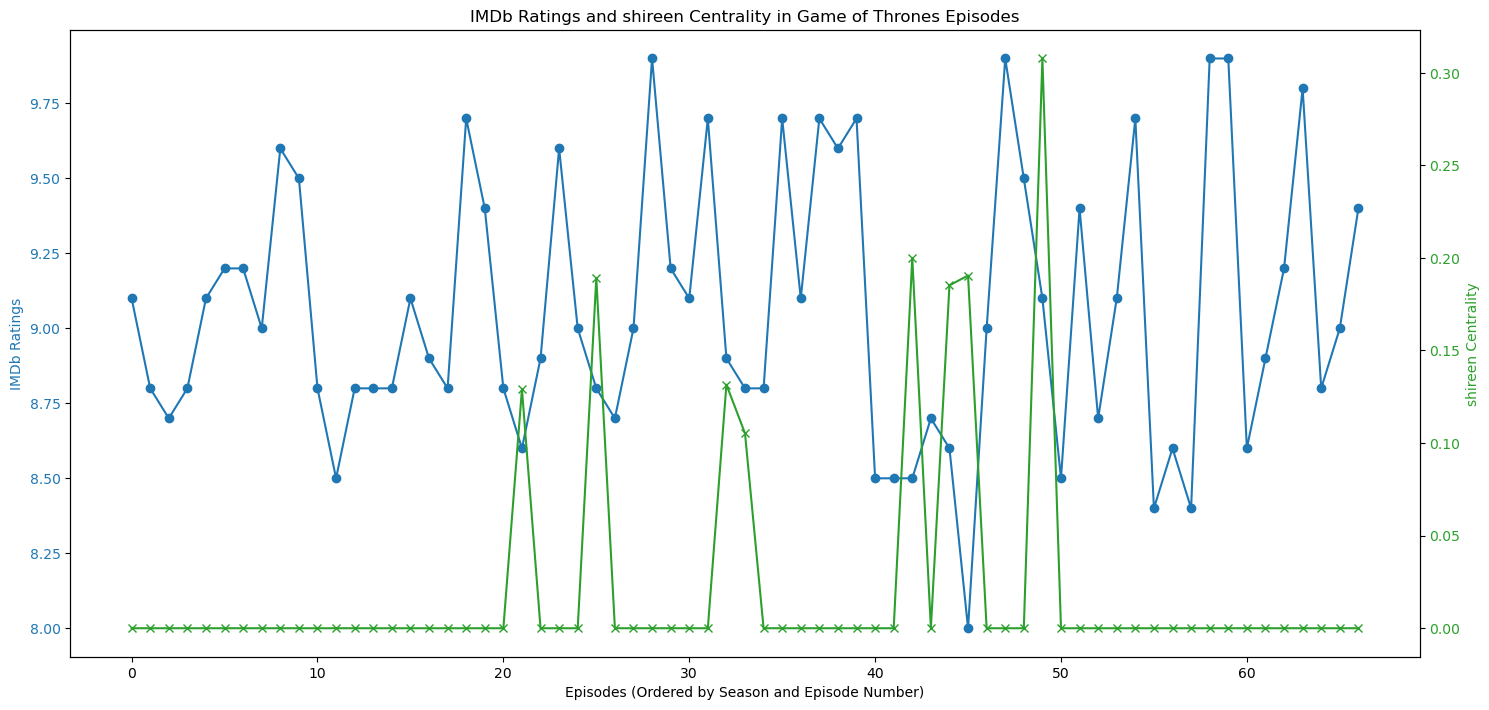

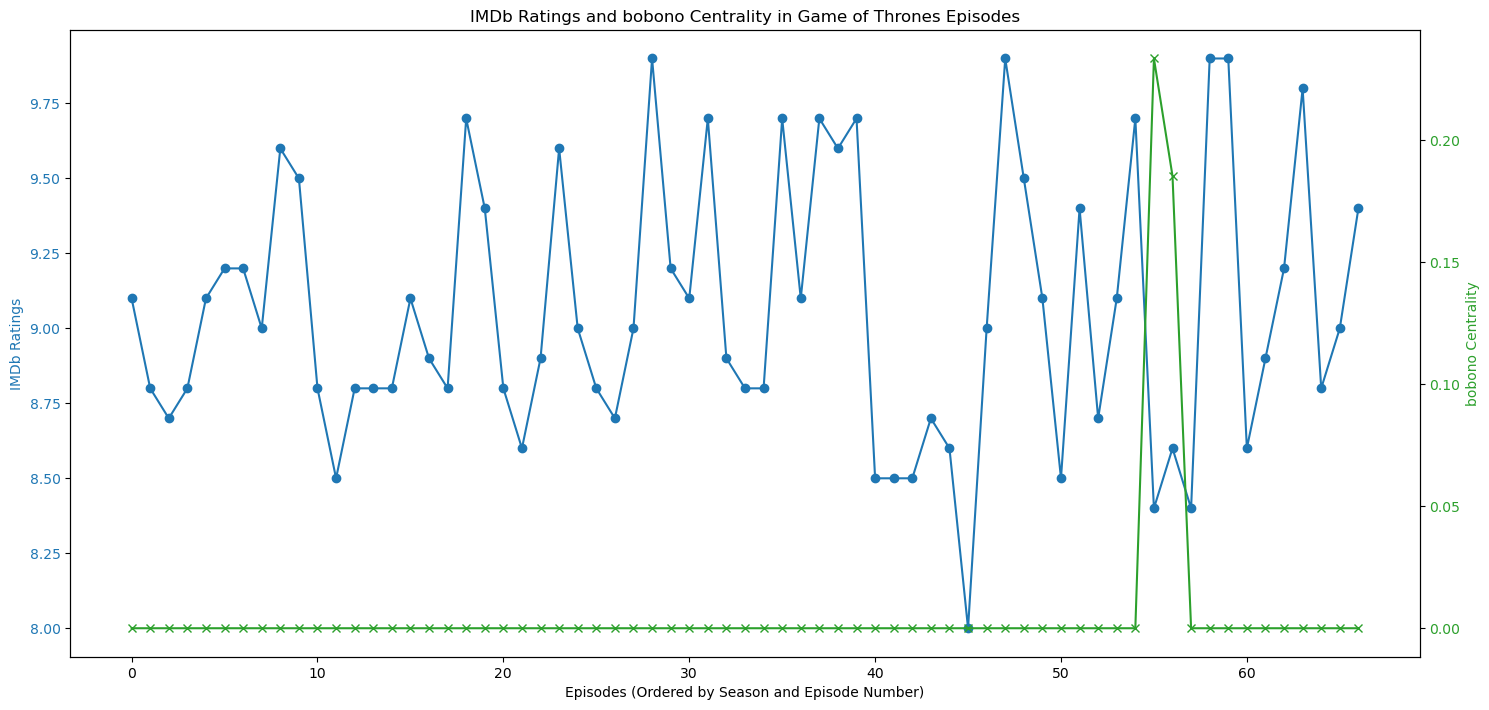

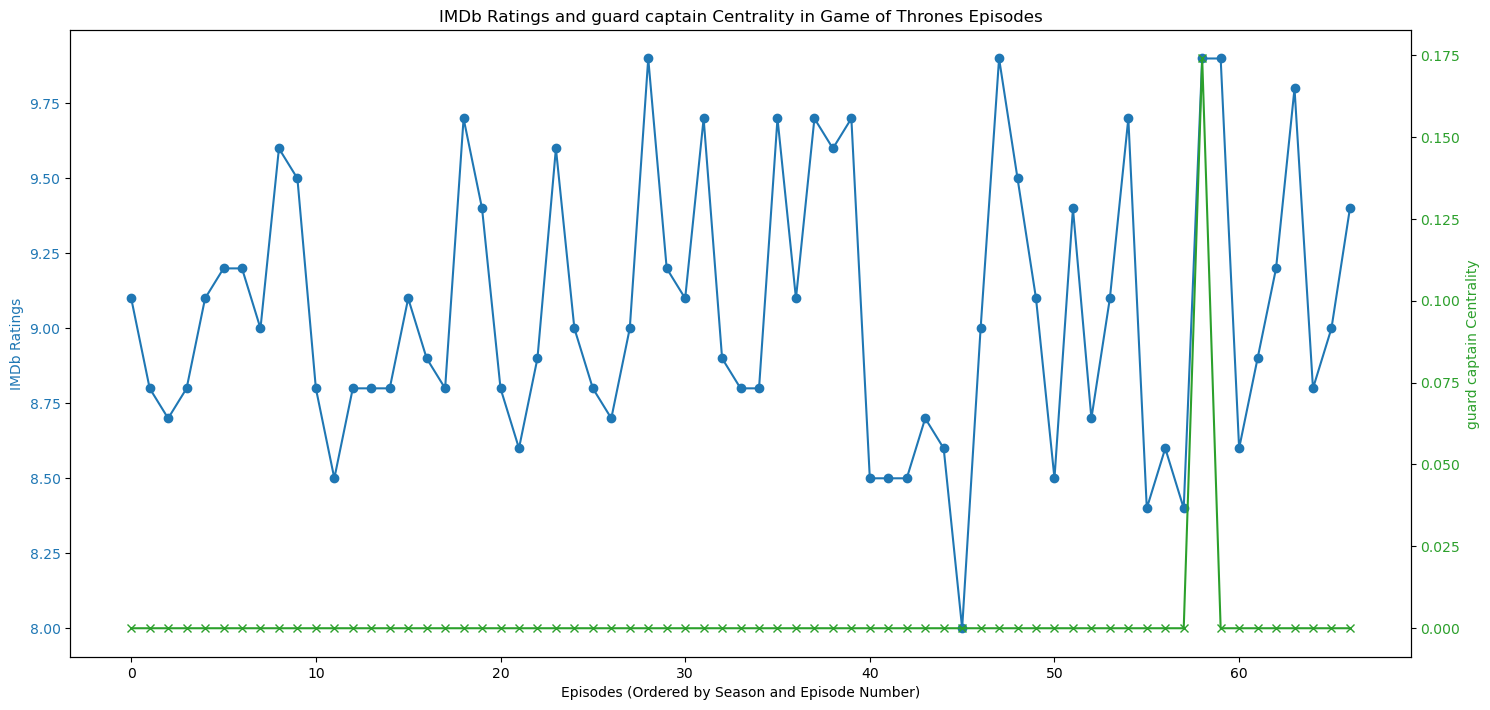

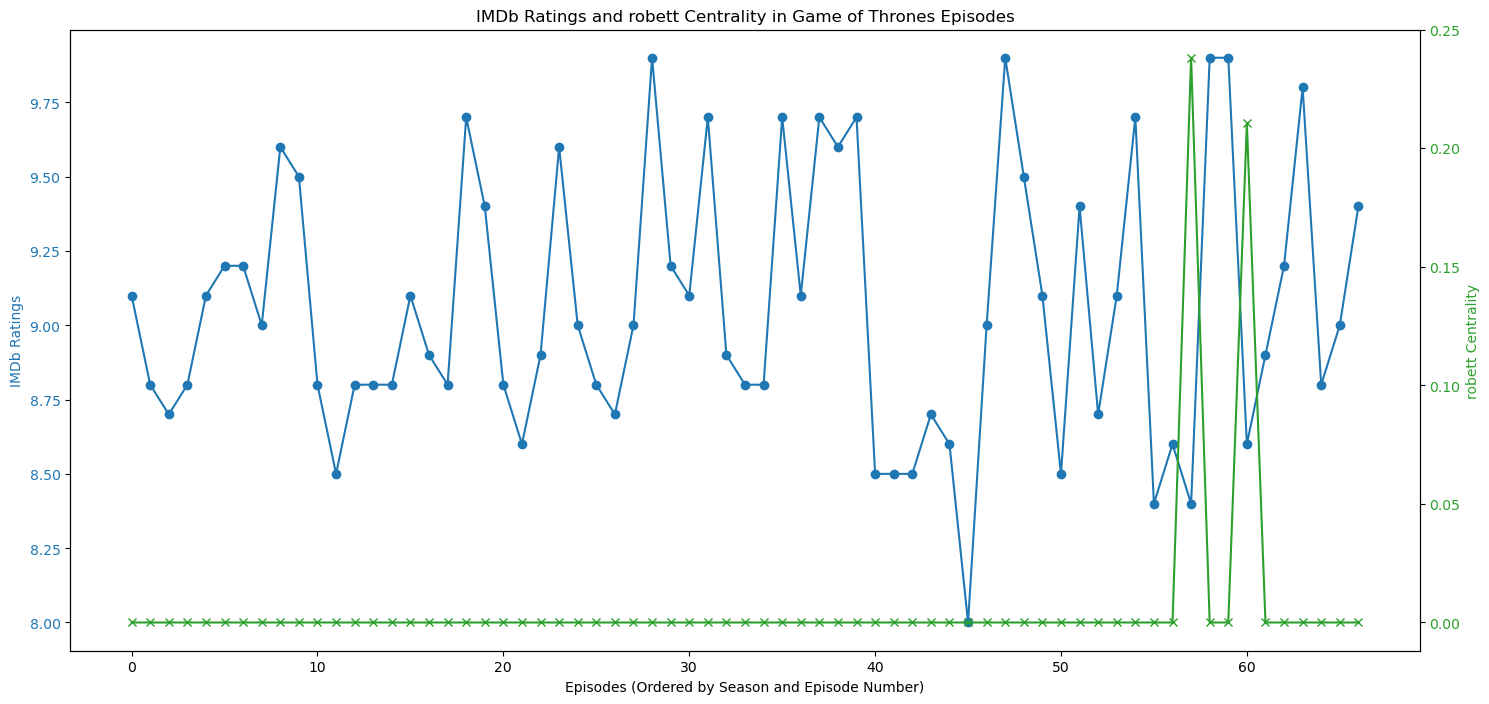

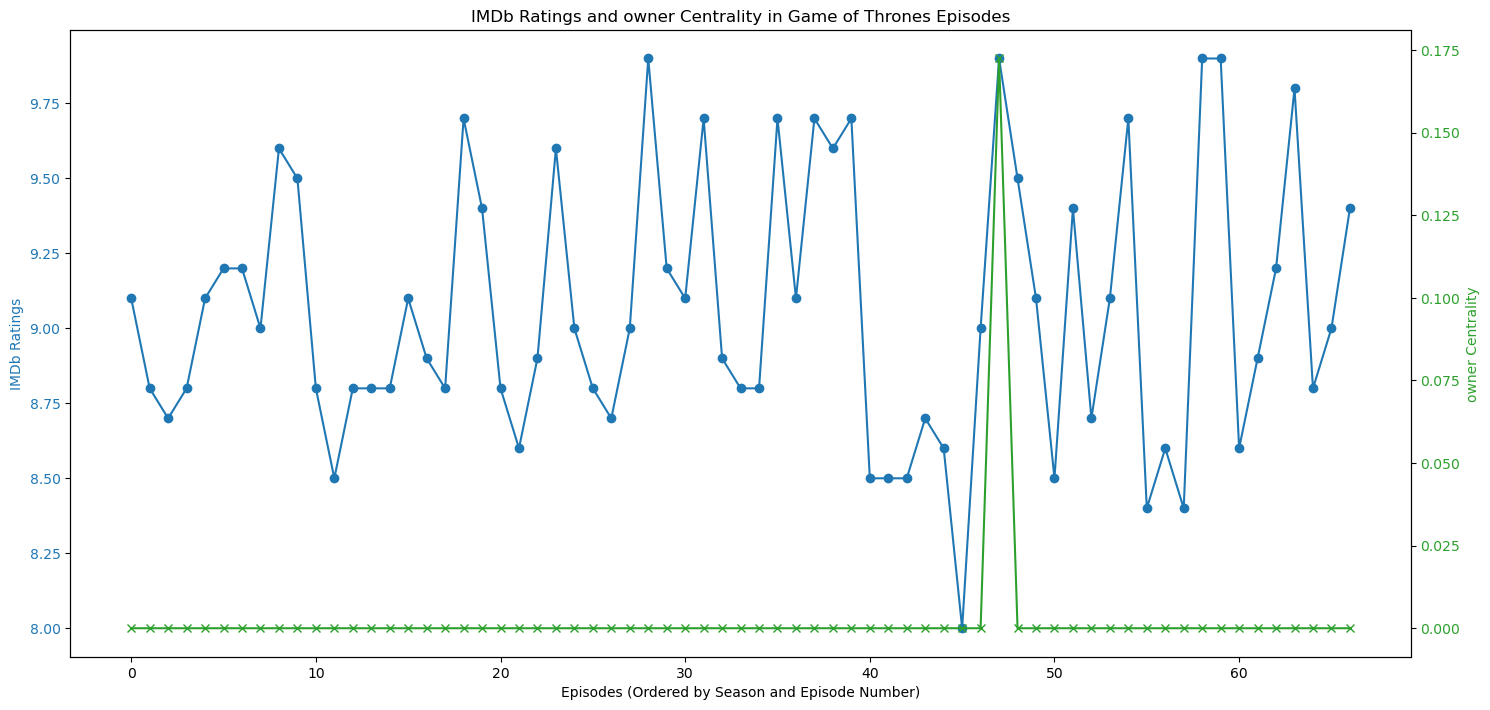

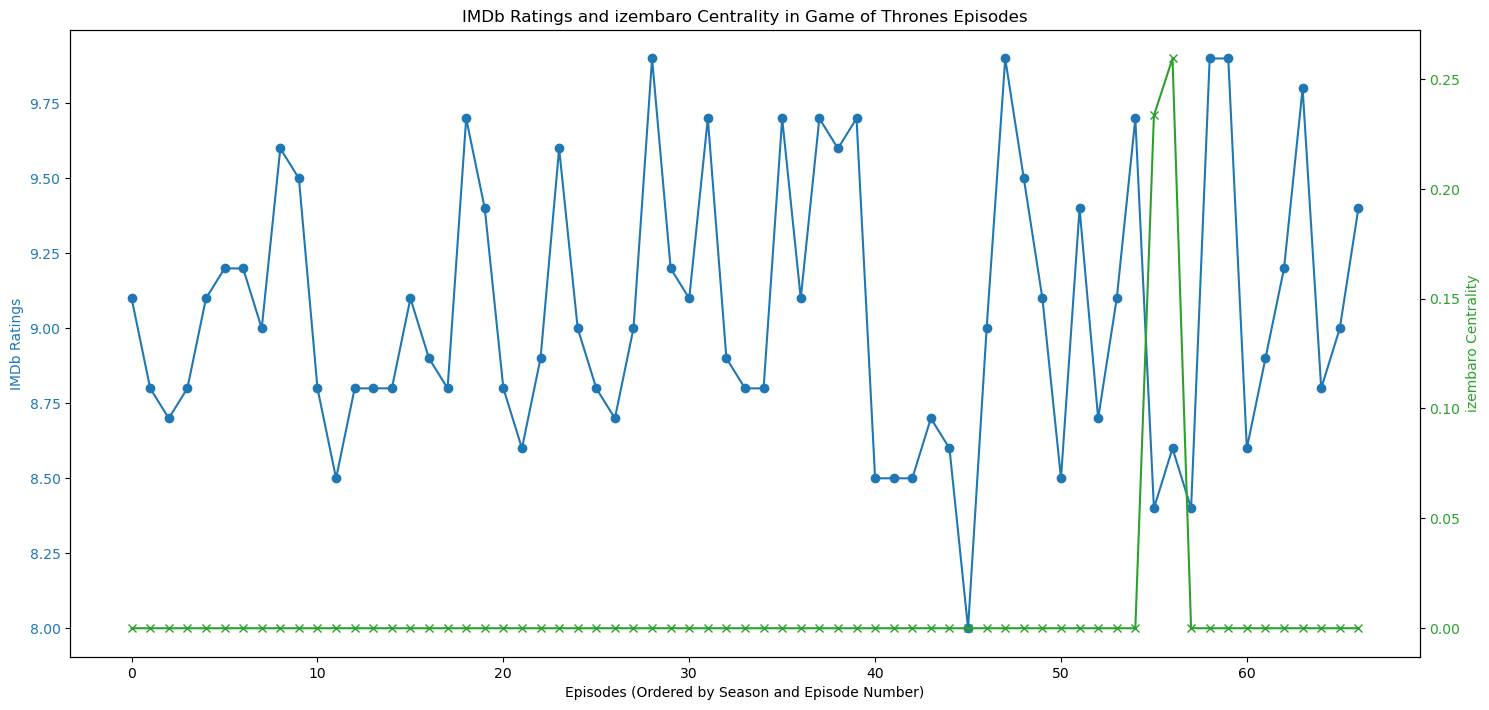

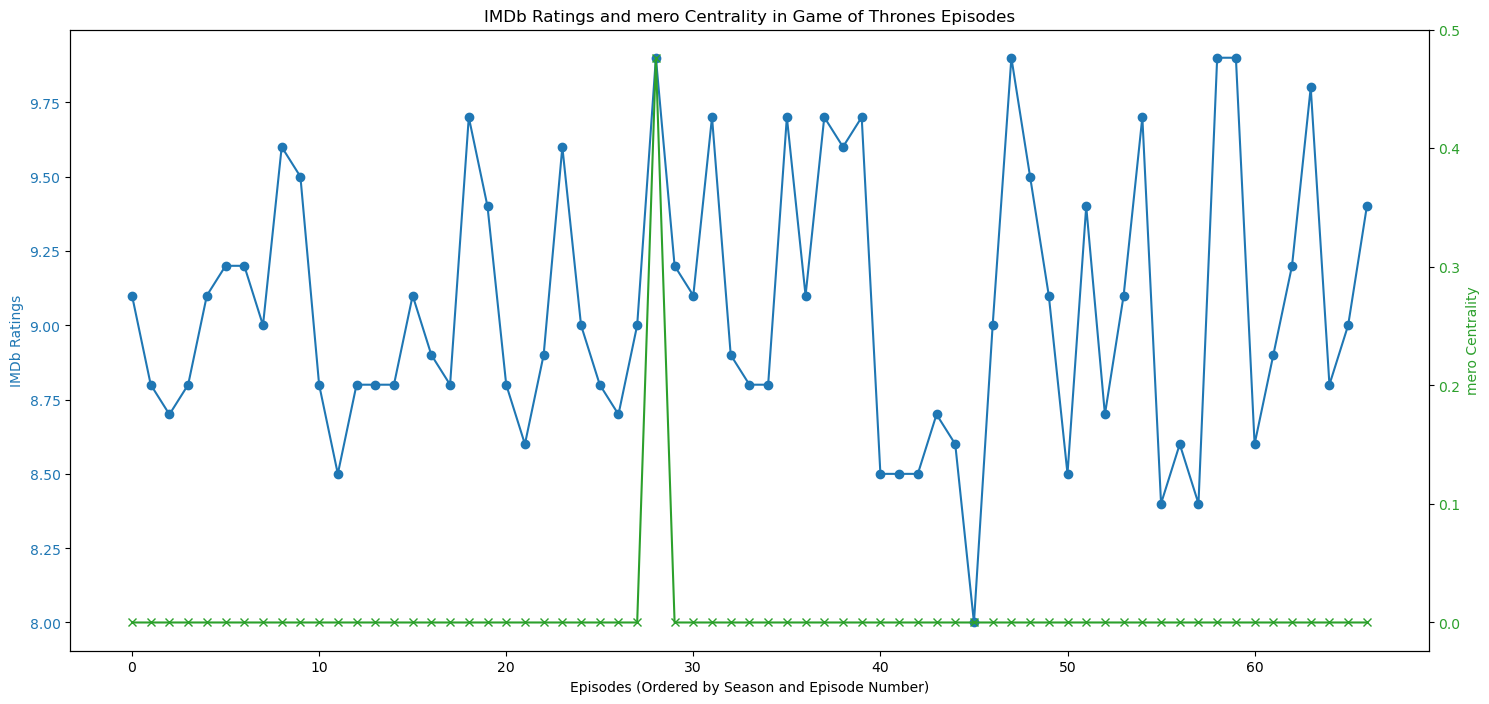

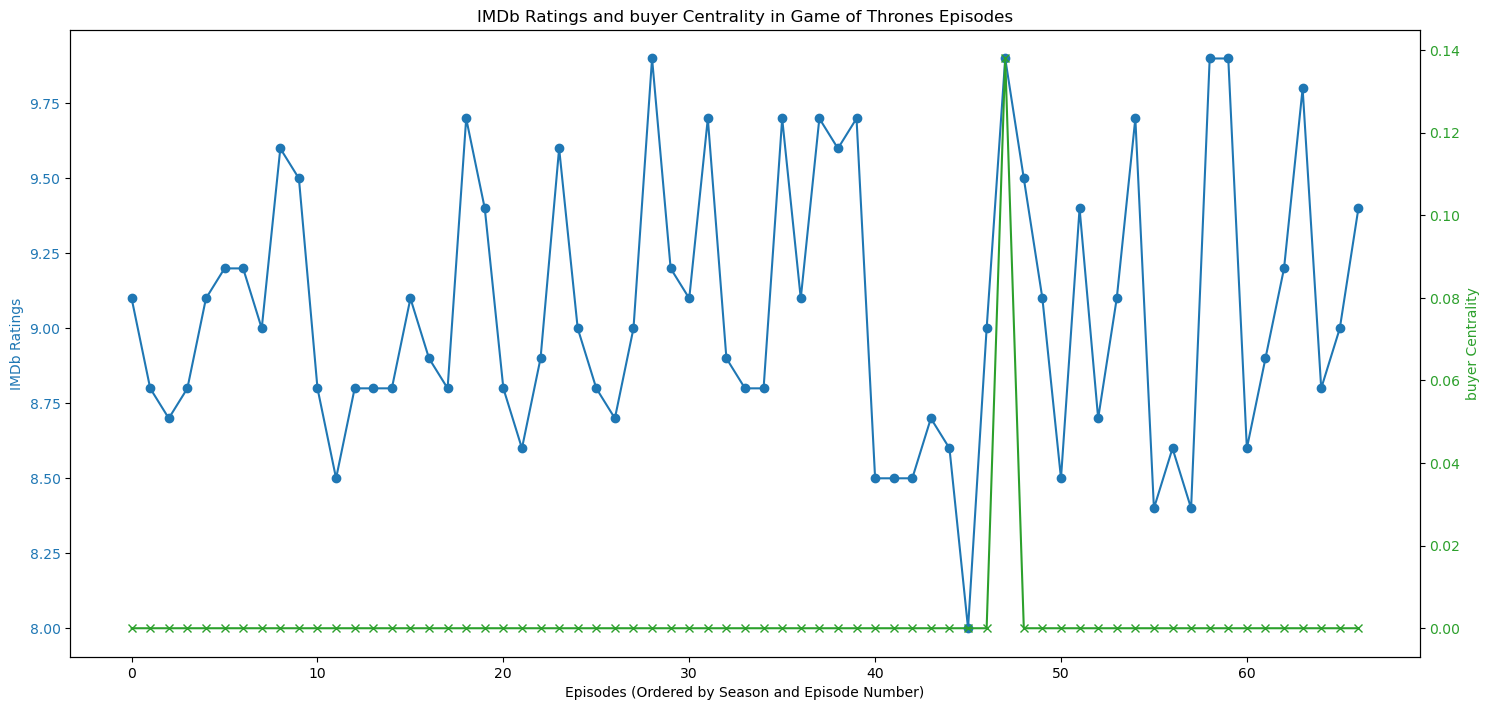

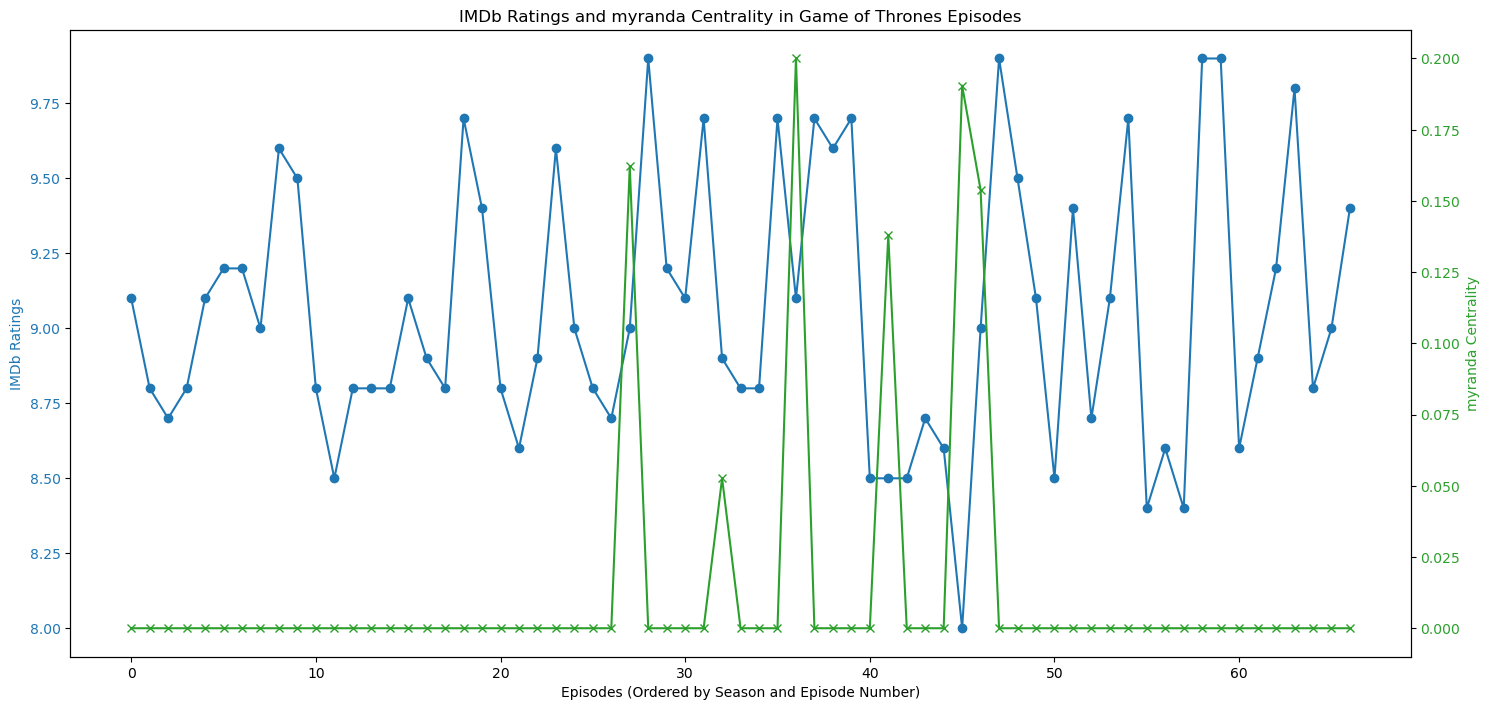

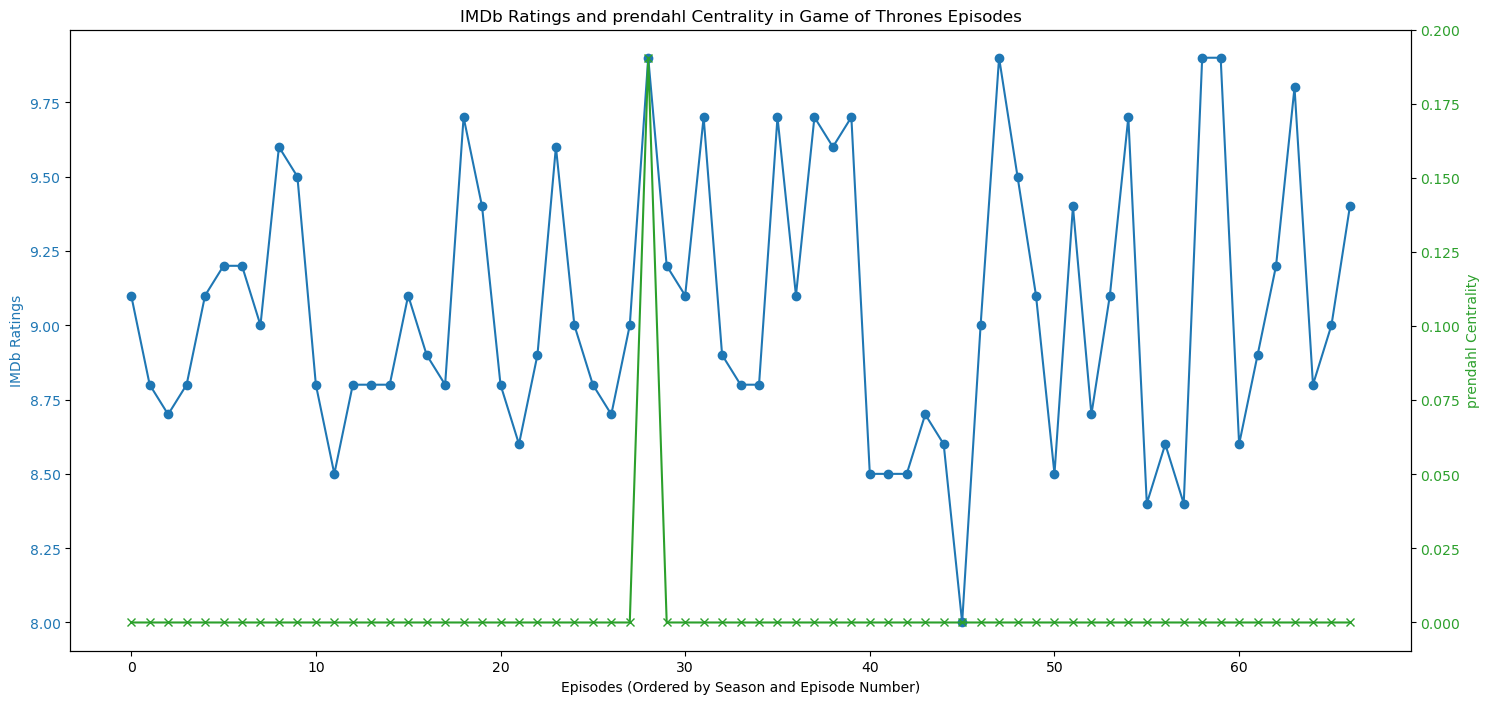

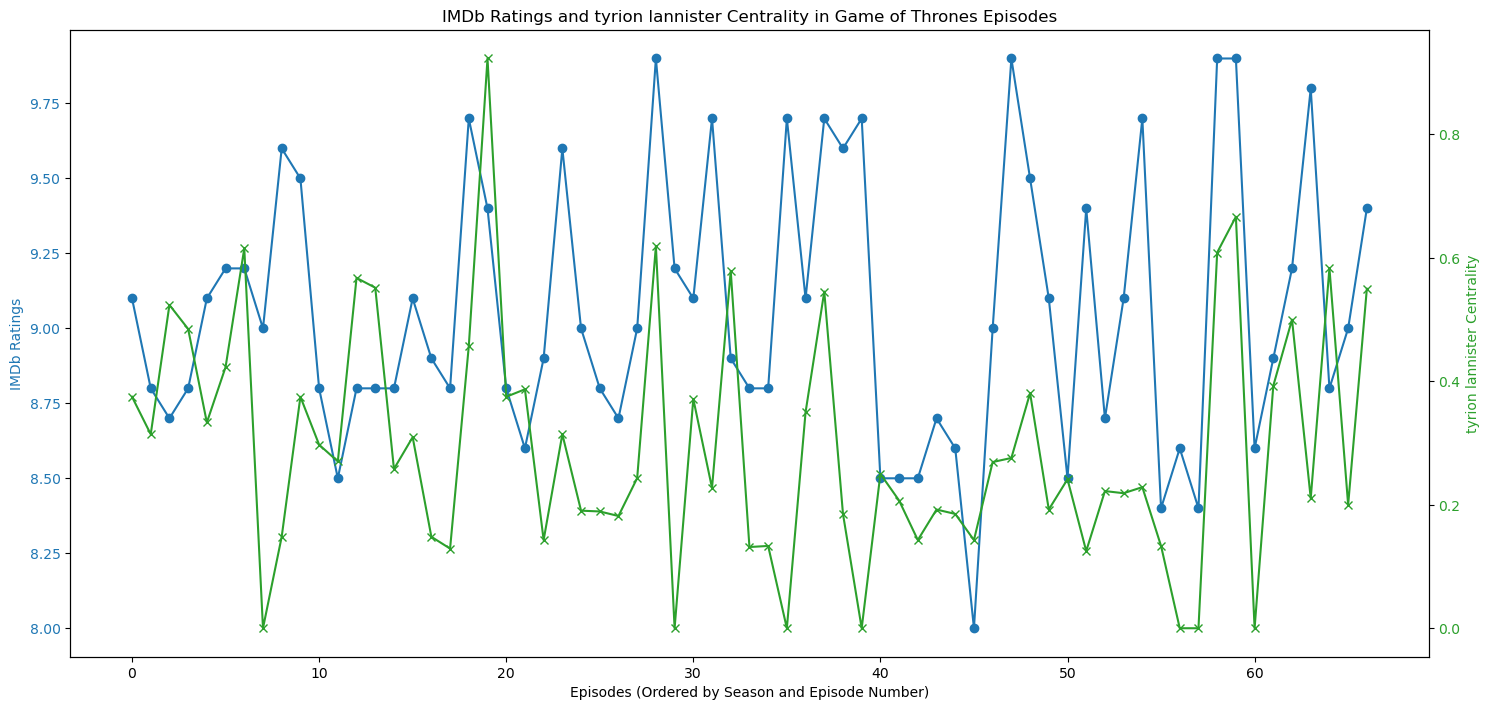

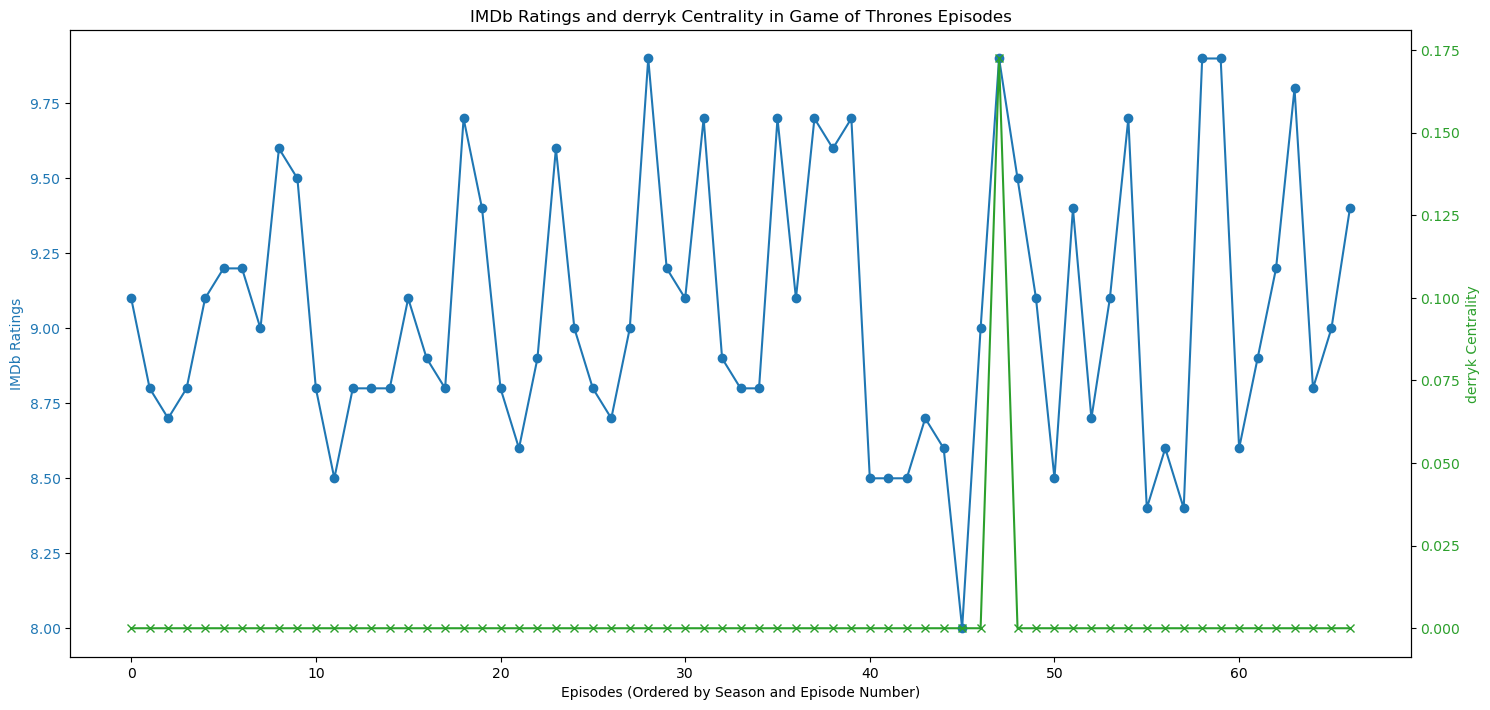

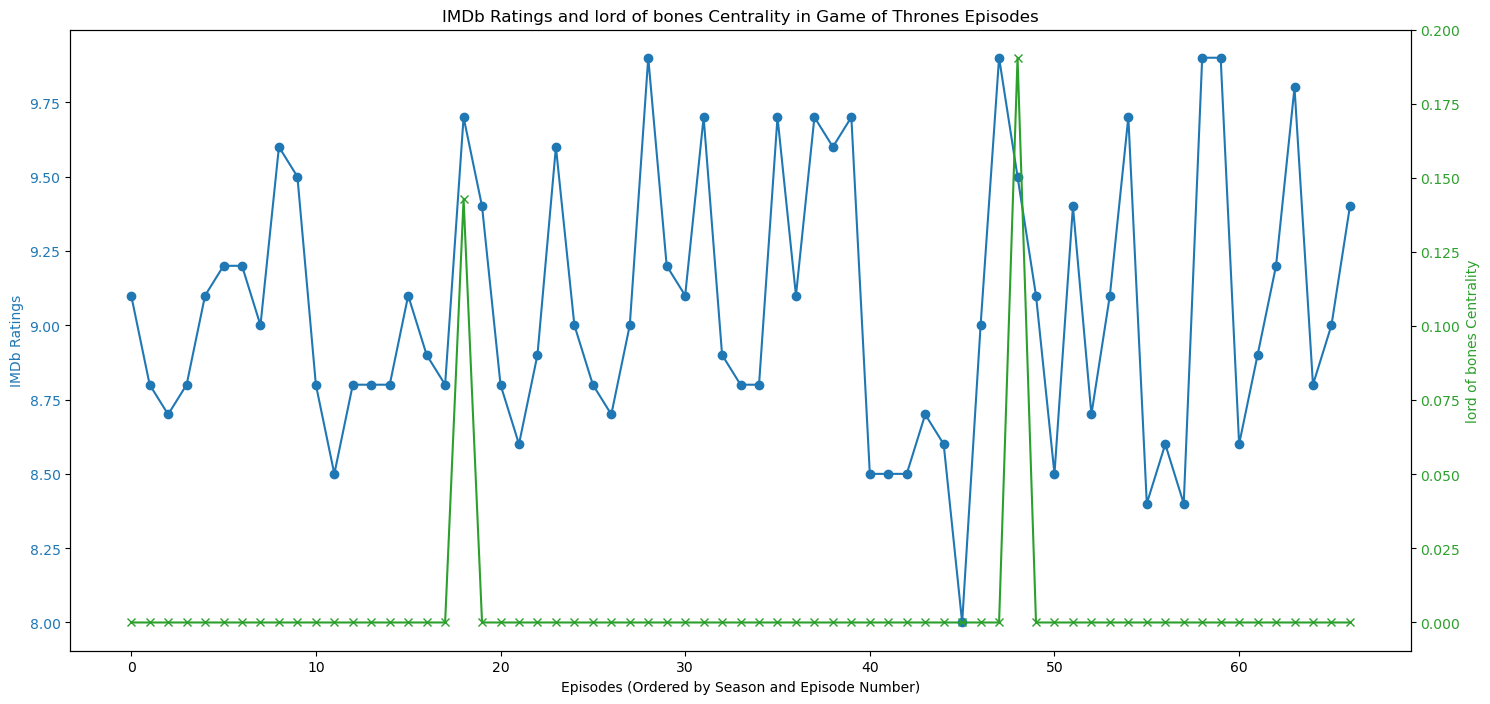

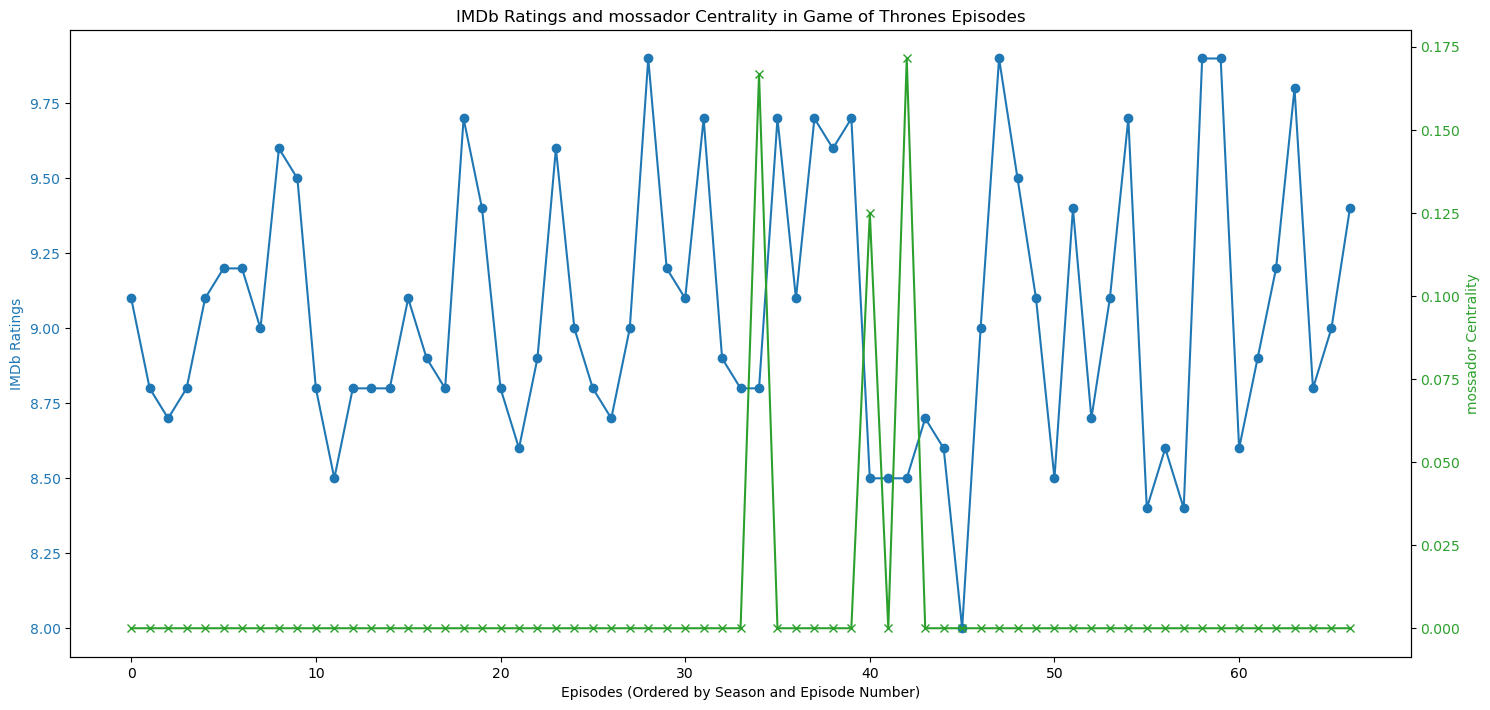

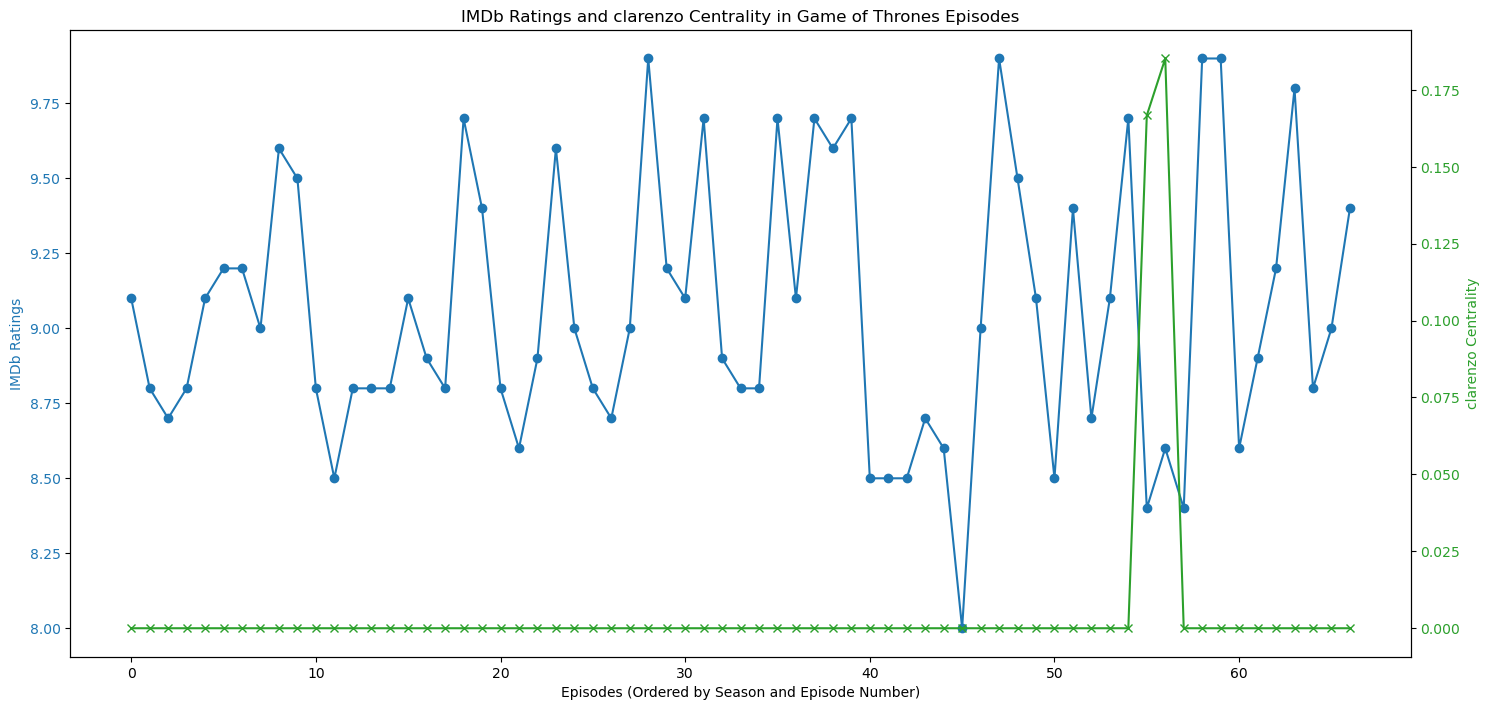

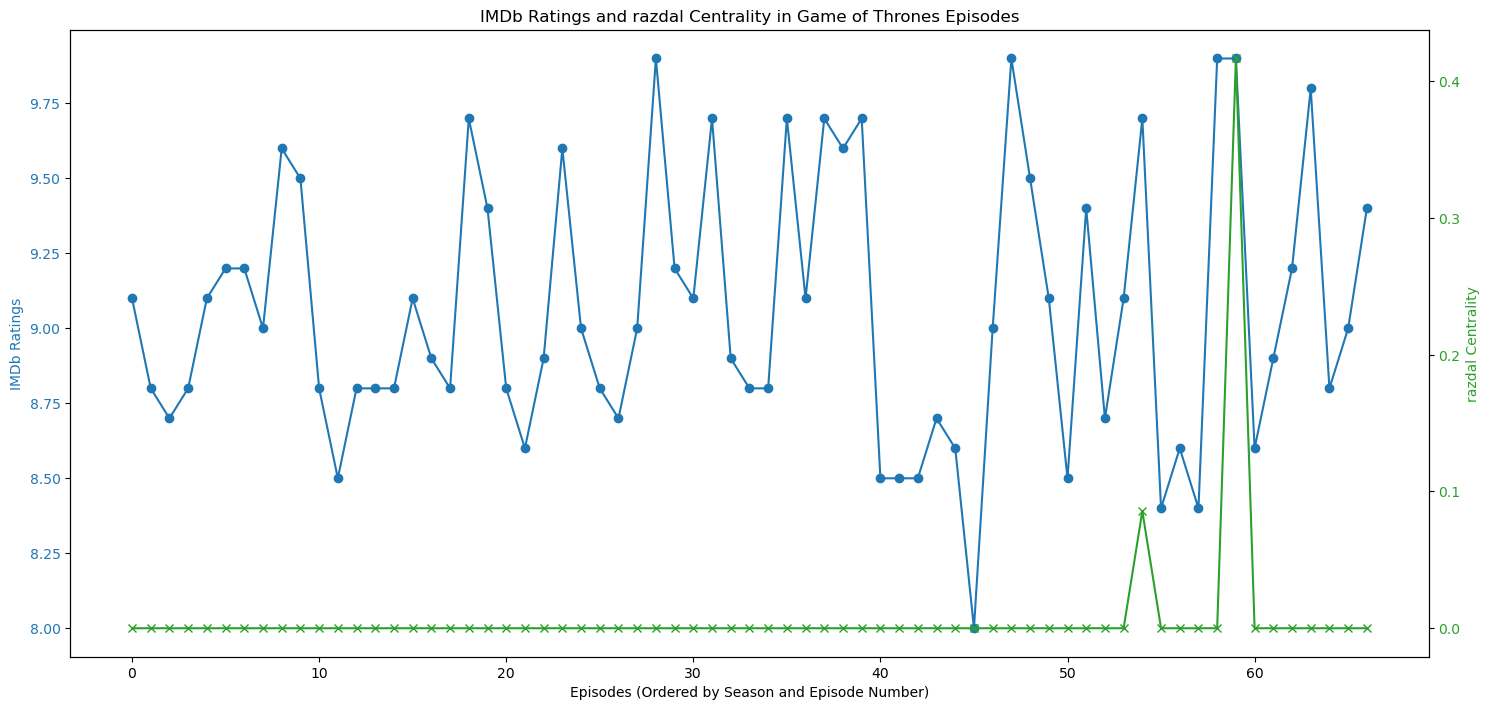

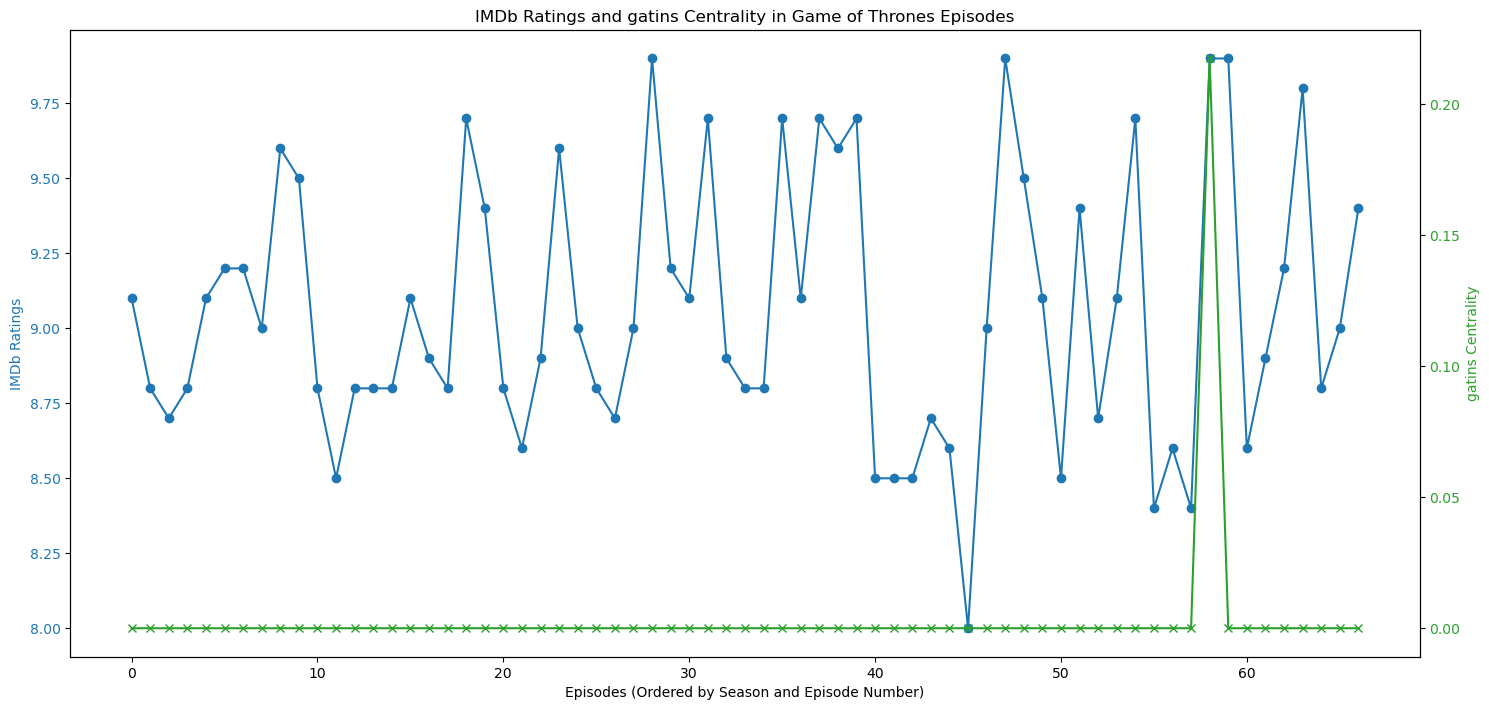

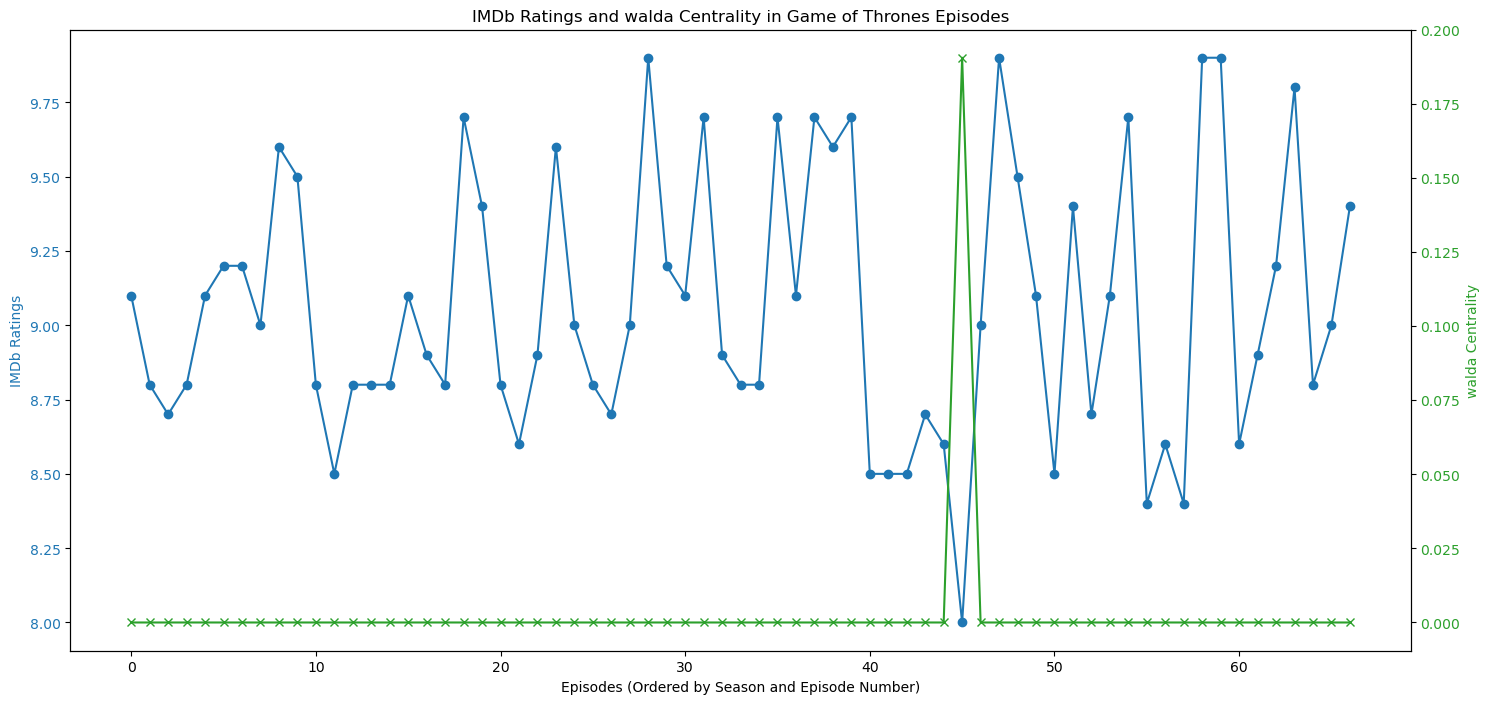

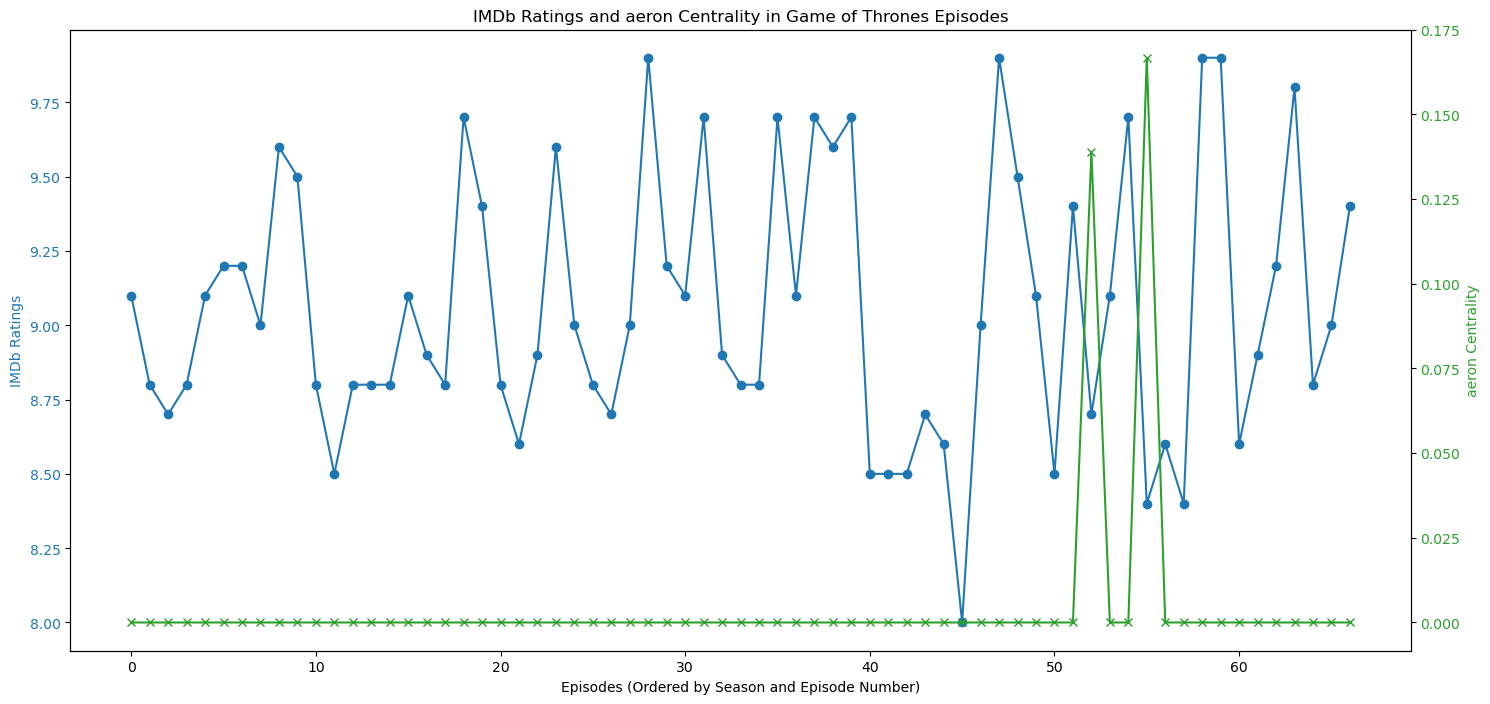

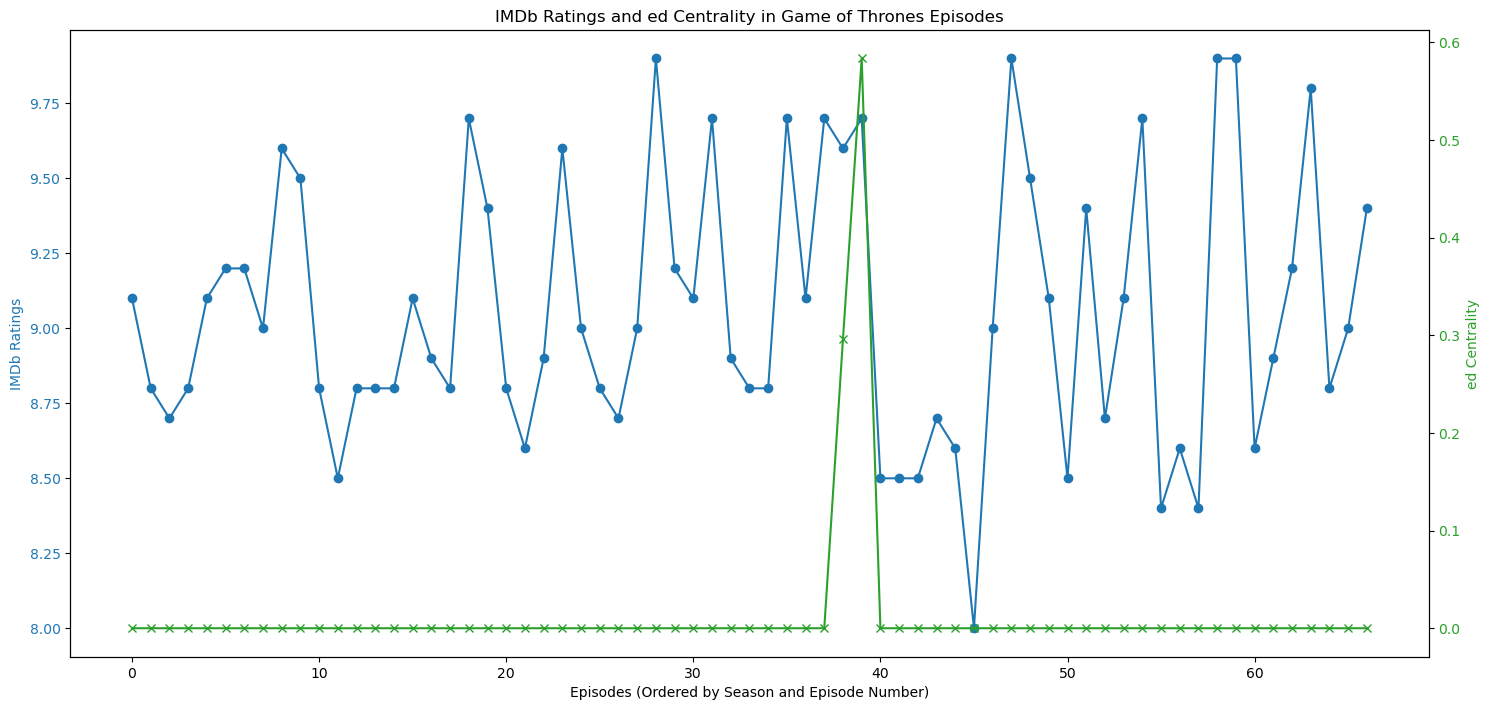

In [10]:
import matplotlib.pyplot as plt

# Identifying the characters with significant correlations
significant_characters = [char for char, (corr, sig) in character_correlations.items() if sig]

# Creating plots for each significant character
for character in significant_characters:
    character_centrality = [all_character_centrality.get(key, {}).get(character, 0) for key in sorted(all_character_centrality)]

    fig, ax1 = plt.subplots(figsize=(15, 7))

    color = 'tab:blue'
    ax1.set_xlabel('Episodes (Ordered by Season and Episode Number)')
    ax1.set_ylabel('IMDb Ratings', color=color)
    ax1.plot(ordered_imdb_scores, color=color, marker='o', label='IMDb Ratings')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:green'
    ax2.set_ylabel(f'{character} Centrality', color=color)
    ax2.plot(character_centrality, color=color, marker='x', label=f'{character} Centrality')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.title(f'IMDb Ratings and {character} Centrality in Game of Thrones Episodes')
    plt.show()


In [11]:
import pandas as pd
import networkx as nx
from collections import Counter
import scipy.stats
import csv

# Load the Game of Thrones scripts data
got_df = pd.read_csv('Game_of_Thrones_Script.csv', delimiter=';')

# Define non-specific characters to filter out
non_specific_characters = [
    "man", "woman", "soldier", "guard", "all", "wife", "male voice", "female voice", "prostitute", "crowd",
    "militant", "thin man", "banker", "girl", "boy", "old man", "young man", "men", "women", "dying man",
    "child", "wildling", "stark guard", "populace", "maid", "storyteller", "kings landing page"
]

# Function to filter out non-specific characters from the interactions
def filter_interactions(interactions):
    filtered_interactions = Counter()
    for pair, count in interactions.items():
        if not any(char in non_specific_characters for char in pair):
            filtered_interactions[pair] = count
    return filtered_interactions

# Modified Function to Process Each Episode with Rolling Window
def process_episode_with_rolling_window(episode_df):
    interactions = Counter()
    num_lines = len(episode_df)

    for i in range(num_lines):
        window_end = min(i + 11, num_lines)  # 11 lines as a window size
        window_df = episode_df.iloc[i:window_end]

        character_counts = Counter(window_df['Name'])
        interacting_characters = [char for char, count in character_counts.items() if count > 1]

        for index, char1 in enumerate(interacting_characters):
            for char2 in interacting_characters[index + 1:]:
                interactions[frozenset([char1, char2])] += 1

    return interactions

# Function to create episode networks with filtered interactions
def create_episode_networks(got_df):
    episode_networks = {}
    for (season, episode), group_df in got_df.groupby(['Season', 'Episode']):
        episode_interactions = process_episode_with_rolling_window(group_df)
        filtered_interactions = filter_interactions(episode_interactions)
        
        G = nx.Graph()
        for pair, count in filtered_interactions.items():
            char1, char2 = tuple(pair)
            G.add_edge(char1, char2, weight=count)
        episode_networks[(season, episode)] = G
    return episode_networks

# Function to calculate centrality for all characters in each episode
def calculate_all_character_centrality(episode_networks):
    character_centrality = {}
    for key, G in episode_networks.items():
        centrality = nx.degree_centrality(G)
        character_centrality[key] = centrality
    return character_centrality

# Create episode networks
episode_networks = create_episode_networks(got_df)

# Calculate centrality for all characters
all_character_centrality = calculate_all_character_centrality(episode_networks)

# Now, parse the IMDb scores
def parse_got_csv(file_path):
    episodes = {}

    with open(file_path, mode='r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        for row in reader:
            season = int(row['Season'])
            episode = int(row['Episode'])
            title = row['Title']
            rating = float(row['Rating'])

            key = (season, episode)
            episodes[key] = {
                'season': season,
                'episode': episode,
                'title': title,
                'rating': rating
            }

    return episodes

# Parse IMDb data
got_imdb_data = parse_got_csv('got_imdb.csv')

# Extract IMDb scores for each episode
imdb_scores = {key: value['rating'] for key, value in got_imdb_data.items()}

all_character_centrality, imdb_scores



({('Season 1', 'Episode 1'): {'will': 0.25,
   'waymar royce': 0.16666666666666666,
   'gared': 0.16666666666666666,
   'jon snow': 0.5833333333333333,
   'septa mordane': 0.16666666666666666,
   'eddard stark': 0.8333333333333333,
   'rodrik cassel': 0.16666666666666666,
   'catelyn stark': 0.7083333333333333,
   'robb stark': 0.375,
   'bran stark': 0.3333333333333333,
   'theon greyjoy': 0.20833333333333331,
   'jaime lannister': 0.3333333333333333,
   'cersei lannister': 0.41666666666666663,
   'robert baratheon': 0.5,
   'arya stark': 0.20833333333333331,
   'sansa stark': 0.4583333333333333,
   'tyrion lannister': 0.375,
   'ros': 0.16666666666666666,
   'viserys targaryen': 0.375,
   'daenerys targaryen': 0.375,
   'illyrio': 0.25,
   'benjen stark': 0.29166666666666663,
   'luwin': 0.16666666666666666,
   'jorah mormont': 0.125,
   'sandor clegane': 0.16666666666666666},
  ('Season 1', 'Episode 10'): {'bran stark': 0.11428571428571428,
   'yoren': 0.17142857142857143,
   'osha'

In [12]:
# Function to calculate the Pearson correlation coefficient between IMDb scores and character centrality
def episode_correlation(episodes, values, significance=0.10):
    """
    Calculate the Pearson correlation coefficient between IMDb scores and given values at the episode level.

    Args:
    episodes (list): List of IMDb scores for each episode.
    values (list): Corresponding values (like centrality scores) to check correlation with IMDb scores.
    significance (float): The significance level to determine statistical significance (default is 0.05).

    Returns:
    tuple: (Pearson correlation coefficient, boolean indicating significance)
    """
    if len(episodes) != len(values):
        raise ValueError("Length of episodes and values must be the same.")

    correlation, p_value = scipy.stats.pearsonr(episodes, values)
    is_significant = p_value < significance
    return correlation, is_significant

# Extract the IMDb scores in the order of episodes as they appear in the centrality data
ordered_imdb_scores = [imdb_scores[key] for key in sorted(imdb_scores)]

# Dictionary to hold correlation results for each character
character_correlations = {}

# Iterate through each character and calculate the correlation with IMDb scores
for character in set().union(*[set(centrality.keys()) for centrality in all_character_centrality.values()]):
    centrality_scores = [all_character_centrality.get(key, {}).get(character, 0) for key in sorted(all_character_centrality)]
    
    # Calculate correlation if the character appears in at least one episode
    if any(centrality_scores):
        correlation, is_significant = episode_correlation(ordered_imdb_scores, centrality_scores)
        character_correlations[character] = (correlation, is_significant)

character_correlations


{'yohn': (0.04571734676170001, False),
 'morag': (0.10798164365729912, False),
 'black lorren': (0.009612288401063814, False),
 'waitress': (-0.041452668892138535, False),
 'davos': (-0.32145931148171475, True),
 'luwin': (0.017364737761907154, False),
 'styr': (0.10757298028920412, False),
 'joffrey dwarf': (0.008358768624340745, False),
 'morgans friend': (0.03326448738258028, False),
 'black walder': (-0.0575579495746539, False),
 'tobho mott': (0.03326448738258033, False),
 'lommy': (-0.00409409075477903, False),
 'shae': (0.08701503129800463, False),
 'robert baratheon': (0.06130965264912185, False),
 'mord': (0.04571734676170012, False),
 'torturer': (0.008358768624340748, False),
 'moles town madam': (-0.0040940907547790326, False),
 'alliser throne': (0.033264487382580275, False),
 'hot pie': (0.10459664564996204, False),
 'master': (0.08307592489905953, False),
 'grand maester pycelle': (0.1828066926244171, False),
 'grenn': (0.17233677361033728, False),
 'yezzan': (0.10798164

In [13]:
# Let's verify the centrality scores for "Tyrion Lannister" across all episodes
tyrion_centrality = [centrality.get("tyrion lannister", 0) for centrality in all_character_centrality.values()]

# Count the number of episodes where Tyrion Lannister has a non-null centrality score
tyrion_episodes_with_centrality = sum(score > 0 for score in tyrion_centrality)

tyrion_episodes_with_centrality, tyrion_centrality



(66,
 [0.375,
  0.3142857142857143,
  0.5238095238095237,
  0.48484848484848486,
  0.33333333333333337,
  0.42307692307692313,
  0.6153846153846154,
  0,
  0.14814814814814814,
  0.375,
  0.2972972972972973,
  0.2702702702702703,
  0.5675675675675675,
  0.5517241379310345,
  0.25806451612903225,
  0.30952380952380953,
  0.14814814814814814,
  0.12903225806451613,
  0.45714285714285713,
  0.9230769230769231,
  0.375,
  0.3870967741935484,
  0.14285714285714285,
  0.3142857142857143,
  0.19047619047619047,
  0.1891891891891892,
  0.18181818181818182,
  0.24324324324324326,
  0.6190476190476191,
  0,
  0.37142857142857144,
  0.2272727272727273,
  0.5789473684210527,
  0.13157894736842105,
  0.13333333333333333,
  0,
  0.35000000000000003,
  0.5454545454545454,
  0.18518518518518517,
  0,
  0.25,
  0.20689655172413793,
  0.14285714285714285,
  0.19230769230769232,
  0.18518518518518517,
  0.14285714285714285,
  0.2692307692307693,
  0.27586206896551724,
  0.38095238095238093,
  0.192307692

In [15]:
# Adjusting the threshold to 1/10 of the total episodes (6-7 episodes)
min_episodes = 67 // 10

# Filter characters based on their appearance in centrality scores (non-null score in at least 1/10 of the episodes)
filtered_characters = {character for character in set().union(*[set(centrality.keys()) for centrality in all_character_centrality.values()])
                       if sum(character in centrality and centrality[character] > 0 for centrality in all_character_centrality.values()) >= min_episodes}

# Displaying the filtered characters
filtered_characters

# Reusing the episode_correlation function to calculate the Pearson correlation
def episode_correlation(episodes, values, significance=0.05):
    """
    Calculate the Pearson correlation coefficient between IMDb scores and given values at the episode level.
    Args:
    episodes (list): List of IMDb scores for each episode.
    values (list): Corresponding values (like centrality scores) to check correlation with IMDb scores.
    significance (float): The significance level to determine statistical significance (default is 0.05).
    Returns:
    tuple: (Pearson correlation coefficient, boolean indicating significance)
    """
    if len(episodes) != len(values):
        raise ValueError("Length of episodes and values must be the same.")

    correlation, p_value = scipy.stats.pearsonr(episodes, values)
    is_significant = p_value < significance
    return correlation, is_significant

# Calculate correlations for the filtered set of characters
filtered_character_correlations = {}
ordered_imdb_scores = [imdb_scores[key] for key in sorted(imdb_scores)]

for character in filtered_characters:
    centrality_scores = [all_character_centrality.get(key, {}).get(character, 0) for key in sorted(all_character_centrality)]
    
    # Calculate correlation if the character appears in at least the minimum number of episodes
    if sum(score > 0 for score in centrality_scores) >= min_episodes:
        correlation, is_significant = episode_correlation(ordered_imdb_scores, centrality_scores)
        filtered_character_correlations[character] = (correlation, is_significant)

filtered_character_correlations




{'locke': (0.0974963544616174, False),
 'davos': (-0.32145931148171475, True),
 'luwin': (0.017364737761907154, False),
 'ros': (0.04403989252810092, False),
 'shae': (0.08701503129800463, False),
 'robert baratheon': (0.06130965264912185, False),
 'jojen': (0.09561584174532463, False),
 'myranda': (-0.03166907143489335, False),
 'barristan': (0.09236449701191683, False),
 'barristan selmy': (0.06692973492089922, False),
 'hot pie': (0.10459664564996204, False),
 'grand maester pycelle': (0.1828066926244171, False),
 'grenn': (0.17233677361033728, False),
 'robb stark': (0.11641031313599122, False),
 'tyrion lannister': (-0.26957567706799257, True),
 'sandor clegane': (-0.17266559421768668, False),
 'theon greyjoy': (0.10218165531629674, False),
 'ygritte': (0.10224659522081193, False),
 'roose bolton': (0.02260935625550327, False),
 'lancel lannister': (0.12259324642182078, False),
 'talisa': (0.08371731908244455, False),
 'olenna tyrell': (0.0711173723194246, False),
 'gendry barathe

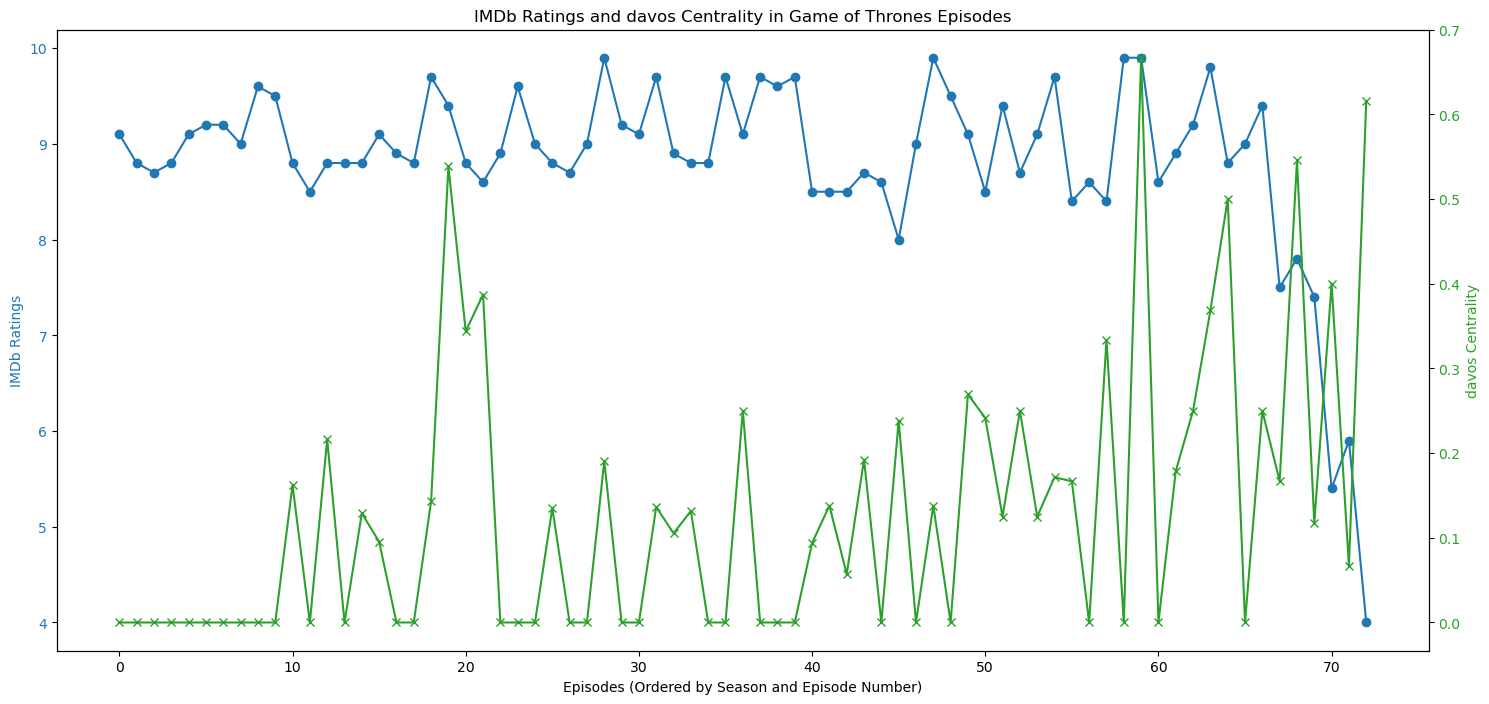

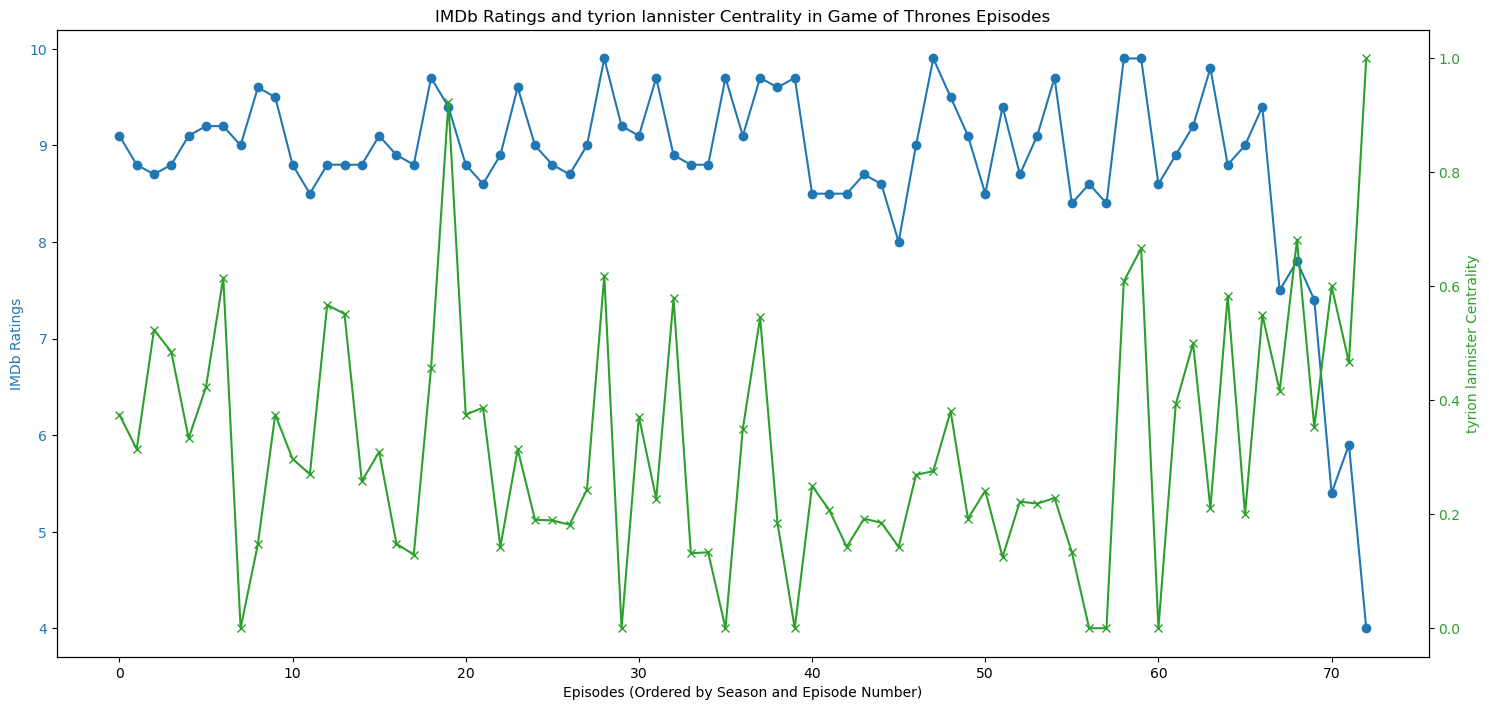

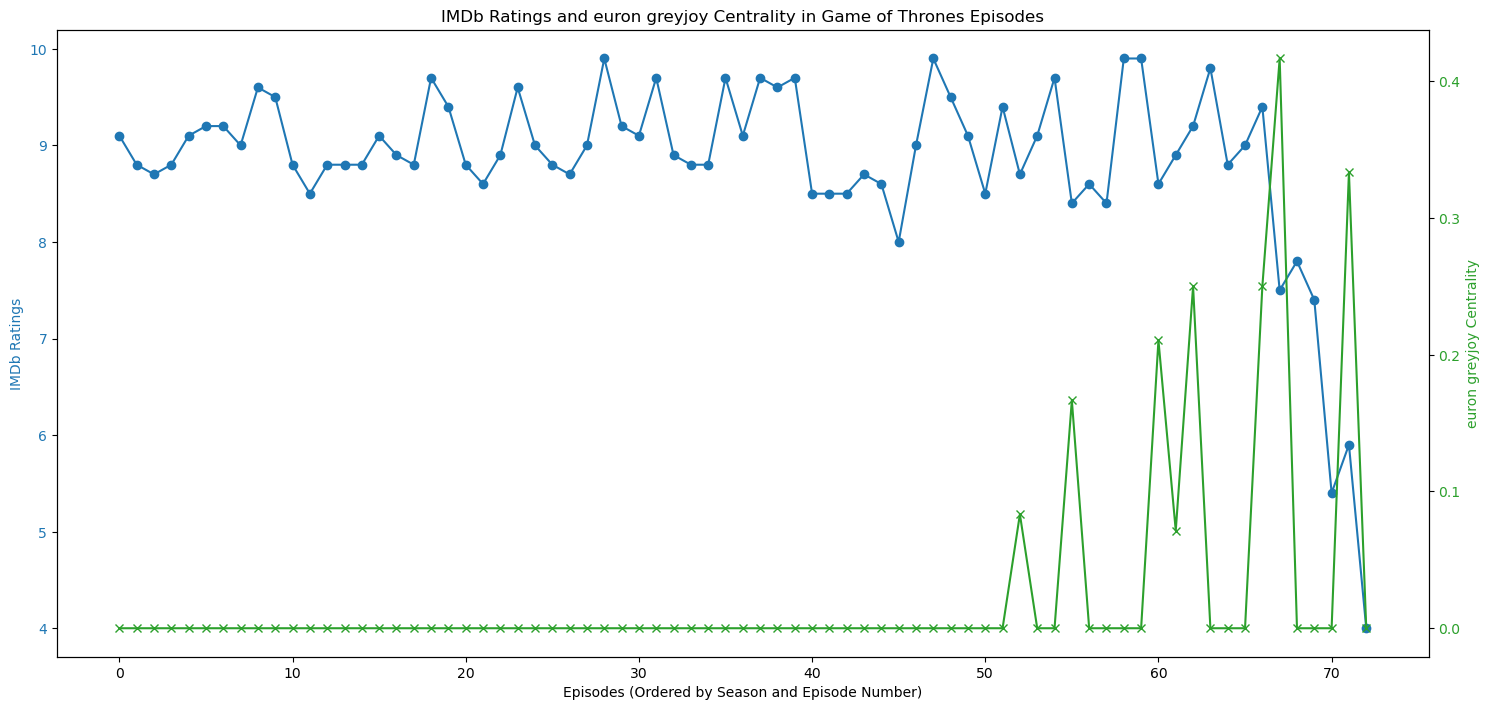

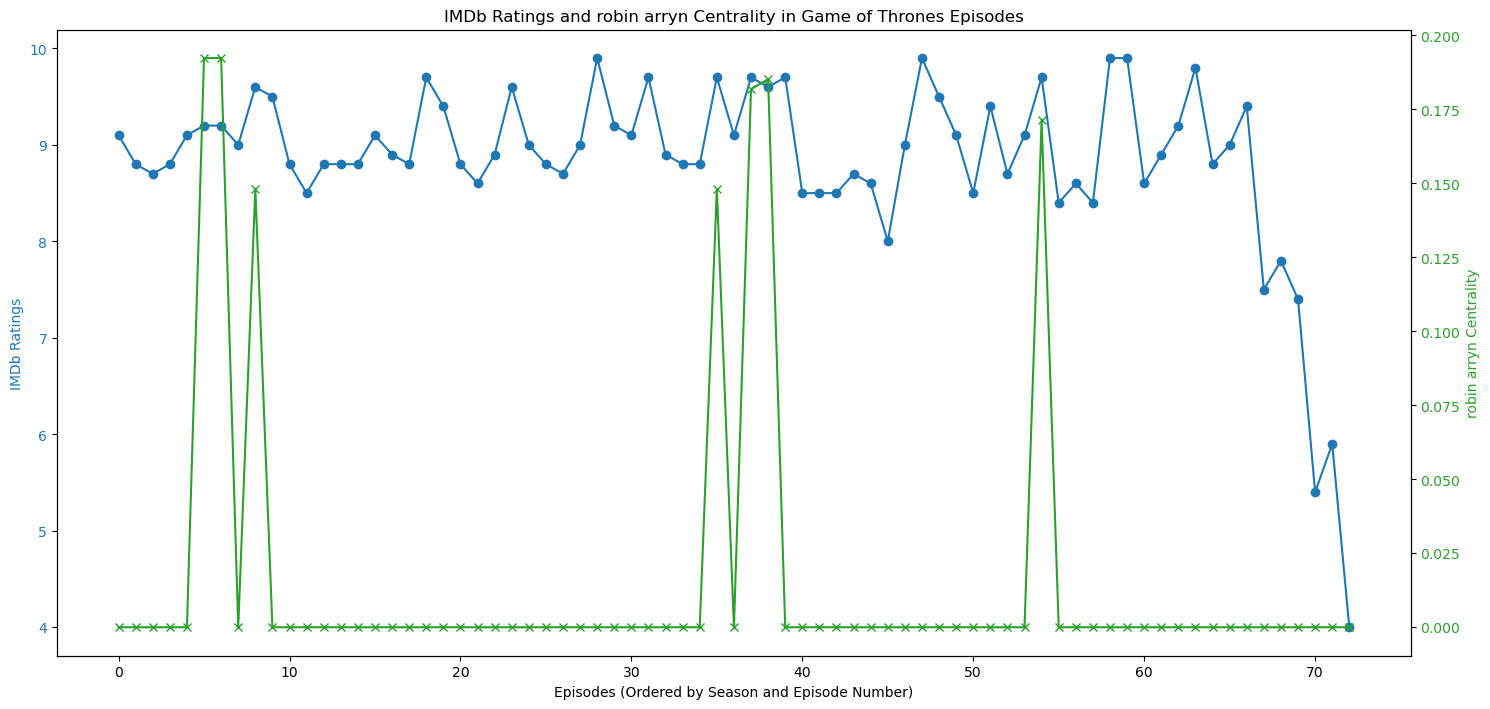

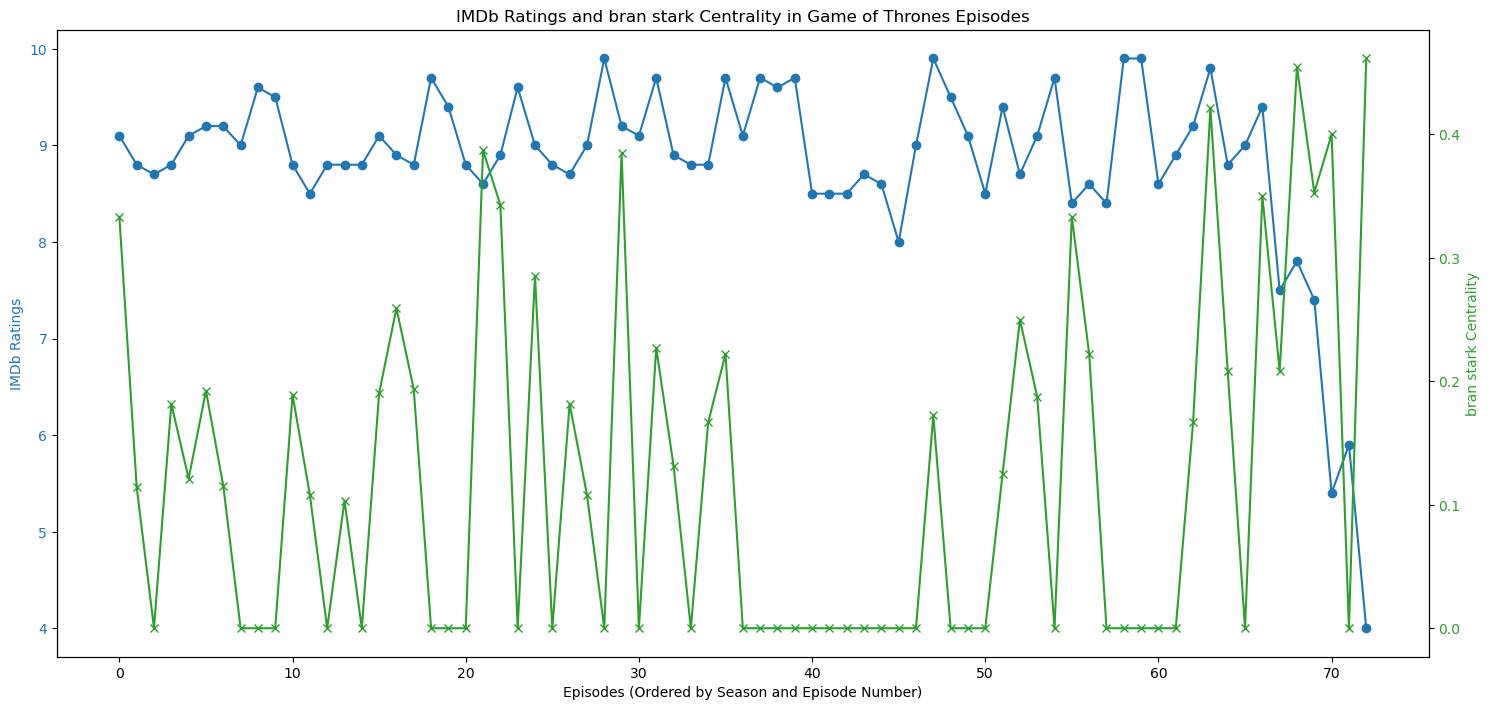

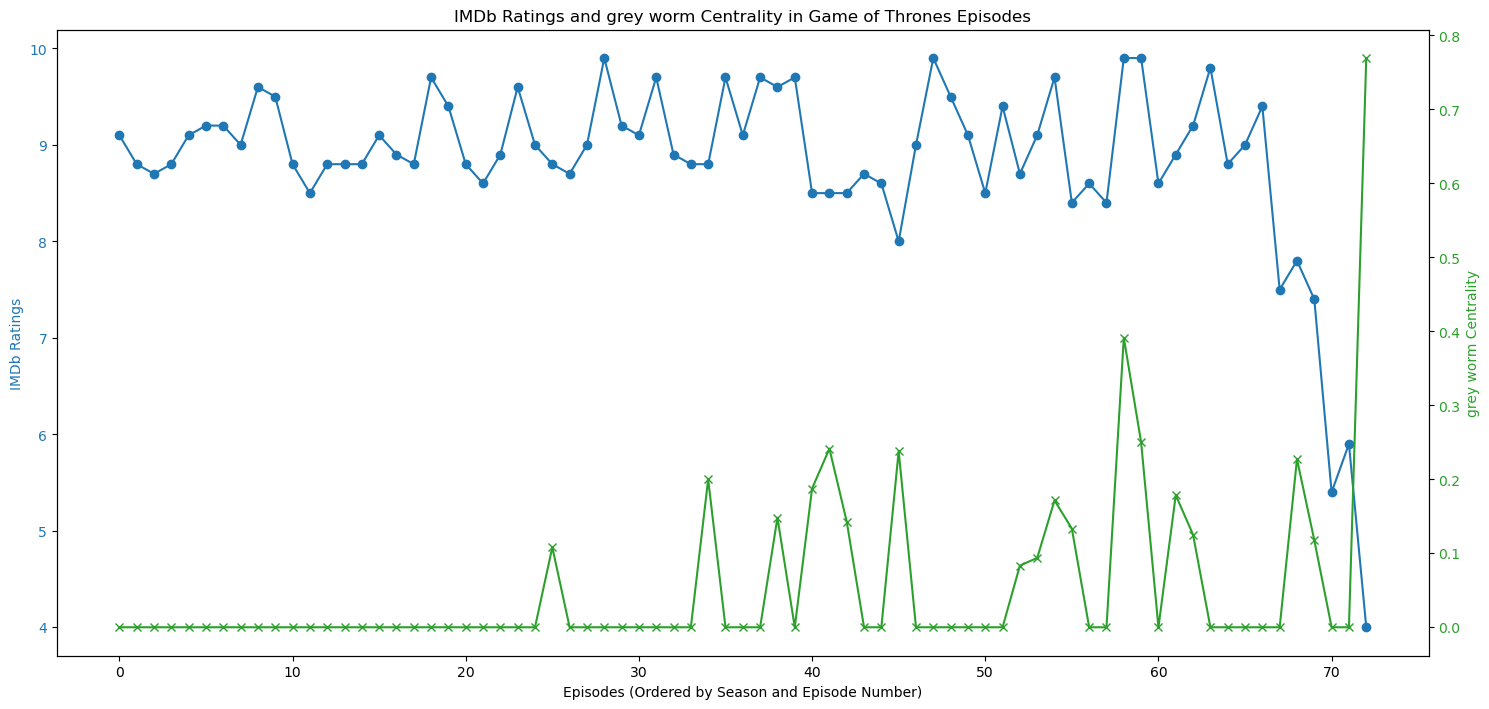

In [16]:
import matplotlib.pyplot as plt

# Identifying the characters with significant correlations
significant_characters = [char for char, (corr, sig) in filtered_character_correlations.items() if sig]

# Creating plots for each significant character
for character in significant_characters:
    character_centrality = [all_character_centrality.get(key, {}).get(character, 0) for key in sorted(all_character_centrality)]

    fig, ax1 = plt.subplots(figsize=(15, 7))

    color = 'tab:blue'
    ax1.set_xlabel('Episodes (Ordered by Season and Episode Number)')
    ax1.set_ylabel('IMDb Ratings', color=color)
    ax1.plot(ordered_imdb_scores, color=color, marker='o', label='IMDb Ratings')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:green'
    ax2.set_ylabel(f'{character} Centrality', color=color)
    ax2.plot(character_centrality, color=color, marker='x', label=f'{character} Centrality')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.title(f'IMDb Ratings and {character} Centrality in Game of Thrones Episodes')
    plt.show()
